## 전처리

In [67]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dbfread import DBF
from haversine import haversine
from tqdm.notebook import tqdm
%matplotlib inline
import platform
import pickle
import re
platform.system()
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'
!pip install dbfread
!pip install haversine

## SKT API 서울시 구별 성별 연령별 일자별 시간별 유동인구

In [73]:
time01 = pd.read_csv('./Floating_Population_2001.csv')
time02 = pd.read_csv('./Floating_Population_2002.csv')
time03 = pd.read_csv('./Floating_Population_2003.csv')
time04 = pd.read_csv('./Floating_Population_2004.csv')
time05 = pd.read_csv('./Floating_Population_2005.csv')
time06 = pd.read_csv('./Floating_Population_2006.csv')
time07 = pd.read_csv('./Floating_Population_2007.csv')
time08 = pd.read_csv('./Floating_Population_2008.csv')

In [74]:
time = pd.concat([time01, time02, time03, time04, time05, time06, time07, time08])
time

,일자,시간(1시간단위),연령대(10세단위),성별,시,군구,유동인구수
0,20200101,0,70,여성,서울,중구,7910
1,20200101,1,20,여성,서울,중구,12330
2,20200101,1,40,여성,서울,구로구,34400
3,20200101,1,40,여성,서울,서대문구,24400
4,20200101,1,50,여성,서울,구로구,36590
...,...,...,...,...,...,...,...
223195,20200831,22,20,남성,서울,서초구,26890
223196,20200831,23,30,남성,서울,성북구,33590
223197,20200831,23,30,여성,서울,동작구,34770
223198,20200831,23,70,여성,서울,금천구,10860


In [75]:
#시는 다 서울이라 필요없다.
del time['시']

In [76]:
time.columns = ['date', 'time', 'age', 'sex', 'gu' , 'ppl']

In [77]:
time['datetime'] = time['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
time

,date,time,age,sex,gu,ppl,datetime
0,20200101,0,70,여성,중구,7910,2020-01-01
1,20200101,1,20,여성,중구,12330,2020-01-01
2,20200101,1,40,여성,구로구,34400,2020-01-01
3,20200101,1,40,여성,서대문구,24400,2020-01-01
4,20200101,1,50,여성,구로구,36590,2020-01-01
...,...,...,...,...,...,...,...
223195,20200831,22,20,남성,서초구,26890,2020-08-31
223196,20200831,23,30,남성,성북구,33590,2020-08-31
223197,20200831,23,30,여성,동작구,34770,2020-08-31
223198,20200831,23,70,여성,금천구,10860,2020-08-31


In [78]:
time = time[['datetime', 'date', 'time', 'gu', 'age', 'ppl', 'sex']]
time

,datetime,date,time,gu,age,ppl,sex
0,2020-01-01,20200101,0,중구,70,7910,여성
1,2020-01-01,20200101,1,중구,20,12330,여성
2,2020-01-01,20200101,1,구로구,40,34400,여성
3,2020-01-01,20200101,1,서대문구,40,24400,여성
4,2020-01-01,20200101,1,구로구,50,36590,여성
...,...,...,...,...,...,...,...
223195,2020-08-31,20200831,22,서초구,20,26890,남성
223196,2020-08-31,20200831,23,성북구,30,33590,남성
223197,2020-08-31,20200831,23,동작구,30,34770,여성
223198,2020-08-31,20200831,23,금천구,70,10860,여성


In [79]:
#저장
with open('time.pkl', 'wb') as f:
    pickle.dump(time, f)

In [80]:
def pklopen(route):
    with open('{}'.format(route), 'rb') as f:
        df = pickle.load(f)
    return df
time = pklopen('./time.pkl')
time

,datetime,date,time,gu,age,ppl,sex
0,2020-01-01,20200101,0,중구,70,7910,여성
1,2020-01-01,20200101,1,중구,20,12330,여성
2,2020-01-01,20200101,1,구로구,40,34400,여성
3,2020-01-01,20200101,1,서대문구,40,24400,여성
4,2020-01-01,20200101,1,구로구,50,36590,여성
...,...,...,...,...,...,...,...
223195,2020-08-31,20200831,22,서초구,20,26890,남성
223196,2020-08-31,20200831,23,성북구,30,33590,남성
223197,2020-08-31,20200831,23,동작구,30,34770,여성
223198,2020-08-31,20200831,23,금천구,70,10860,여성


In [81]:
#구의 종류
time['gu'].unique()

array(['중구', '구로구', '서대문구', '성동구', '송파구', '용산구', '성북구', '영등포구', '동작구',
       '중랑구', '노원구', '양천구', '강남구', '강서구', '관악구', '강동구', '은평구', '마포구',
       '도봉구', '종로구', '서초구', '동대문구', '강북구', '광진구', '금천구'], dtype=object)

In [82]:
gu_list = list(time['gu'].unique())
gu_list

['중구',
 '구로구',
 '서대문구',
 '성동구',
 '송파구',
 '용산구',
 '성북구',
 '영등포구',
 '동작구',
 '중랑구',
 '노원구',
 '양천구',
 '강남구',
 '강서구',
 '관악구',
 '강동구',
 '은평구',
 '마포구',
 '도봉구',
 '종로구',
 '서초구',
 '동대문구',
 '강북구',
 '광진구',
 '금천구']

In [83]:
#나이 종류
time['age'].unique()

array([70, 20, 40, 50, 30, 60], dtype=int64)

In [84]:
time_sorted = time.sort_values(by=['age', 'datetime', 'time'], axis=0)
time_sorted

,datetime,date,time,gu,age,ppl,sex
4109,2020-01-01,20200101,0,금천구,20,14220,여성
6151,2020-01-01,20200101,0,중랑구,20,25030,남성
10330,2020-01-01,20200101,0,강남구,20,43680,남성
24665,2020-01-01,20200101,0,도봉구,20,19950,남성
30655,2020-01-01,20200101,0,양천구,20,29620,남성
...,...,...,...,...,...,...,...
201627,2020-08-31,20200831,23,송파구,70,17330,남성
203554,2020-08-31,20200831,23,동대문구,70,18500,여성
215311,2020-08-31,20200831,23,중구,70,4920,남성
223198,2020-08-31,20200831,23,금천구,70,10860,여성


In [85]:
time_sorted.set_index(['datetime', 'time'])

date    gu  age    ppl sex
datetime   time                                
2020-01-01 0     20200101   금천구   20  14220  여성
           0     20200101   중랑구   20  25030  남성
           0     20200101   강남구   20  43680  남성
           0     20200101   도봉구   20  19950  남성
           0     20200101   양천구   20  29620  남성
...                   ...   ...  ...    ...  ..
2020-08-31 23    20200831   송파구   70  17330  남성
           23    20200831  동대문구   70  18500  여성
           23    20200831    중구   70   4920  남성
           23    20200831   금천구   70  10860  여성
           23    20200831   성북구   70  22700  여성

[1747200 rows x 5 columns]

## 구별, 일별, 시간별 같은 연령끼리 유동인구

In [86]:
timeday = time_sorted.groupby(['datetime', 'date', 'gu', 'age', 'time']).sum()
timeday = timeday.reset_index()
#2월 1일 기준 20대 한번 보자(1월은 명절)
k = timeday[timeday['datetime']=='2020-02-01'].head(24)
k

,datetime,date,gu,age,time,ppl
111600,2020-02-01,20200201,강남구,20,0,85360
111601,2020-02-01,20200201,강남구,20,1,83380
111602,2020-02-01,20200201,강남구,20,2,81670
111603,2020-02-01,20200201,강남구,20,3,80830
111604,2020-02-01,20200201,강남구,20,4,80150
111605,2020-02-01,20200201,강남구,20,5,79960
111606,2020-02-01,20200201,강남구,20,6,80830
111607,2020-02-01,20200201,강남구,20,7,83890
111608,2020-02-01,20200201,강남구,20,8,92110
111609,2020-02-01,20200201,강남구,20,9,104370


Text(0.5, 1.0, '2월1일 강남구 20대의 시간별 유동인구')

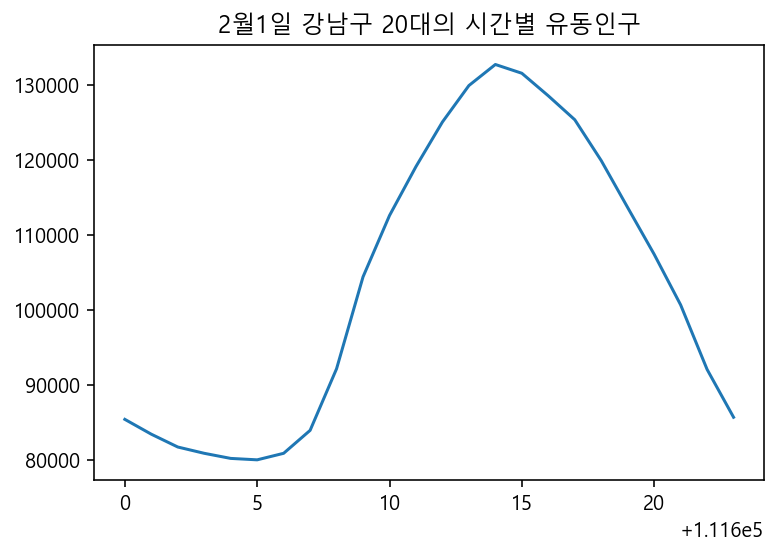

In [87]:
plt.plot(k['ppl'])
plt.title('2월1일 강남구 20대의 시간별 유동인구')

## 이제 구별 일별 민감도(연령별은 나중에 추가하기)

In [88]:
timegu = time_sorted.groupby(['datetime', 'date','gu','age']).sum()
timegu = timegu.reset_index()
# del timegu['age']
del timegu['time']
timegu.set_index(['datetime'], inplace=True)
timegu['week'] =0
timegu.reset_index(inplace=True)
timegu['week']=timegu['datetime'].dt.week
timegu

,datetime,date,gu,age,ppl,week
0,2020-01-01,20200101,강남구,20,2117660,1
1,2020-01-01,20200101,강남구,30,2320520,1
2,2020-01-01,20200101,강남구,40,2309160,1
3,2020-01-01,20200101,강남구,50,1990390,1
4,2020-01-01,20200101,강남구,60,1332770,1
...,...,...,...,...,...,...
36445,2020-08-31,20200831,중랑구,30,1284500,36
36446,2020-08-31,20200831,중랑구,40,1349950,36
36447,2020-08-31,20200831,중랑구,50,1503880,36
36448,2020-08-31,20200831,중랑구,60,979260,36


In [89]:
fpop_gu = timegu.groupby(['gu','age', 'week'])['ppl'].sum().divide(7000000).round(2).reset_index()
age_gu = fpop_gu.set_index('gu')
age_gu.loc['강남구']

,age,week,ppl
gu,,,
강남구,20,1,1.90
강남구,20,2,2.98
강남구,20,3,2.99
강남구,20,4,2.46
강남구,20,5,2.71
...,...,...,...
강남구,70,32,0.90
강남구,70,33,0.90
강남구,70,34,0.88


In [90]:
## 주차별 유동인구 데이터 시각화 함수
def plot_region_fpop(df, gu_nm=None, dong_code=None):
  if gu_nm is not None:
    region = gu_nm
    tmp_df = df[df.gu==gu_nm].copy()\
                .groupby('week')['ppl'].sum().divide(7000000).round(2).reset_index()
  elif dong_code is not None:
    region = f'{timegu.loc[timegu.adstrd_code == dong_code, "gu"].iloc[0]} ' +\
             f'{timegu.loc[timegu.adstrd_code == dong_code, "adstrd_nm"].iloc[0]}'
    tmp_df = df[df.adstrd_code==dong_code].copy()\
                .groupby('week')['ppl'].sum().divide(7000).round(2).reset_index()
  else:
    region = '서울시'
    tmp_df = timegu.groupby('week')['ppl'].sum().divide(7000000).round(2).reset_index()
  
  pre_fpop = tmp_df.loc[tmp_df.week.isin(range(2,4)), 'ppl'].sum()/2
  post_fpop = tmp_df.loc[tmp_df.week.isin(range(9,13)), 'ppl'].sum()/4
  fpop_sensitivity = round((pre_fpop - post_fpop)/(pre_fpop), 3)

  tmp_df['week'] = tmp_df['week'].apply(lambda x : f'weekofyear_{x}')
  

  plt.figure(figsize=(18, 6))
  pal = sns.color_palette("Greens_d", tmp_df.shape[0])
  rank = tmp_df['ppl'].argsort().argsort()
  sns.barplot(x='week', y='ppl', data=tmp_df, palette=np.array(pal[::-1])[rank])
  plt.plot([1.5, 9.5], [pre_fpop, post_fpop], '-or', label=f'{region} 코로나19 유동인구 민감도 : {fpop_sensitivity}')
  plt.text(1, pre_fpop*1.05, f'2-3주차 평균\n({pre_fpop:.3f})', size=15)
  plt.text(9, post_fpop*1.05, f'9-12주차 평균\n({post_fpop:.3f})', size=15)
  plt.axvspan(1.5-1, 1.5+1, color='red', alpha=0.2)
  plt.axvspan(9.5-2, 9.5+2, color='red', alpha=0.2)

  plt.title(f'{region} 주차별 일평균 유동인구', size=20)
  plt.xticks(rotation=45, size=15, ha='right')
  plt.xlabel('주차별', size=15)
  ylabel = '유동인구수(천명)' if dong_code is not None else '유동인구수(백만명)'
  plt.ylabel(ylabel, size=15)
  plt.legend(fontsize=15, loc='upper right')
  plt.ylim(0, tmp_df.ppl.max()*1.2)
  plt.show()


In [91]:
#민감도 랭킹 시각화 함수
def plot_region_fpop_sensitivity(df, x_axis, rot_x=True, show_xlabel=True):
  plt.figure(figsize=(18, 6))

  pal = sns.color_palette("Oranges_r", df.shape[0])
  rank = df['코로나19_유동인구_민감도'].argsort().argsort()
  sns.barplot(x=x_axis, y='코로나19_유동인구_민감도', data=df, palette=np.array(pal[::-1])[rank])
  plt.axhline(0.15, color='red', alpha=0.5, label='서울시 전체 코로나19 유동인구 민감도')
  for idx, score in enumerate(df.코로나19_유동인구_민감도):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

  plt.title(f'서울시 {x_axis}별 코로나19 유동인구 민감도', size=25)
  plt.legend(fontsize=15)
  plt.ylabel('코로나19 유동인구 민감도', size=15)
  if rot_x:
    plt.xticks(rotation=45, size=15, ha='right')
  if show_xlabel:
    plt.xlabel(x_axis, size=15)
  else:
    plt.xlabel(None)

  plt.show()

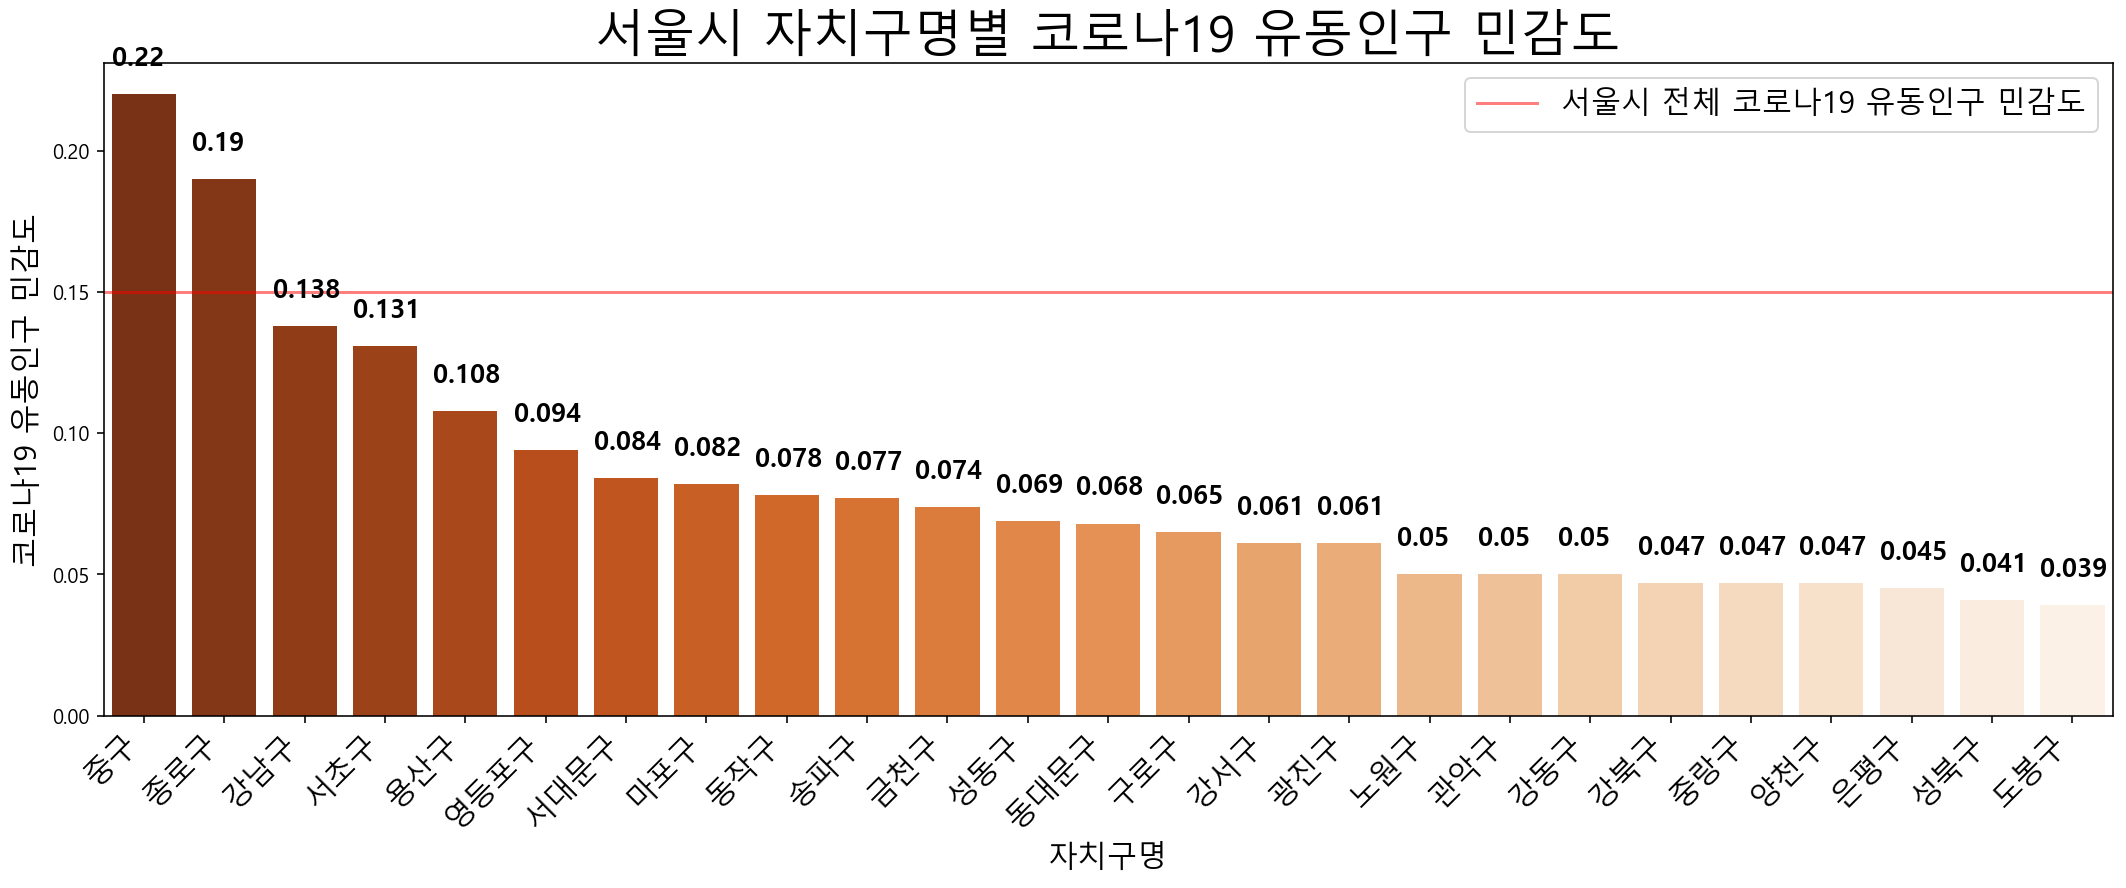

In [92]:
tmp_list = []
for gu in fpop_gu.gu.unique():
  tmp_df = fpop_gu[fpop_gu.gu==gu]
  tmp_pre = tmp_df.loc[fpop_gu.week.isin(range(2,4)), 'ppl'].mean()
  tmp_post = tmp_df.loc[fpop_gu.week.isin(range(9, 12)), 'ppl'].mean()
  tmp_sensitivity = round((tmp_pre - tmp_post)/tmp_pre, 3)
  tmp_list.append(tmp_sensitivity)

fpop_sensitivity_gu = pd.DataFrame({'자치구명':fpop_gu.gu.unique(), '코로나19_유동인구_민감도':tmp_list})\
                        .sort_values('코로나19_유동인구_민감도', ascending=False).reset_index(drop=True)

# 자치구별 코로나19 유동인구 민감도 막대 그래프
plot_region_fpop_sensitivity(df=fpop_sensitivity_gu, x_axis='자치구명')



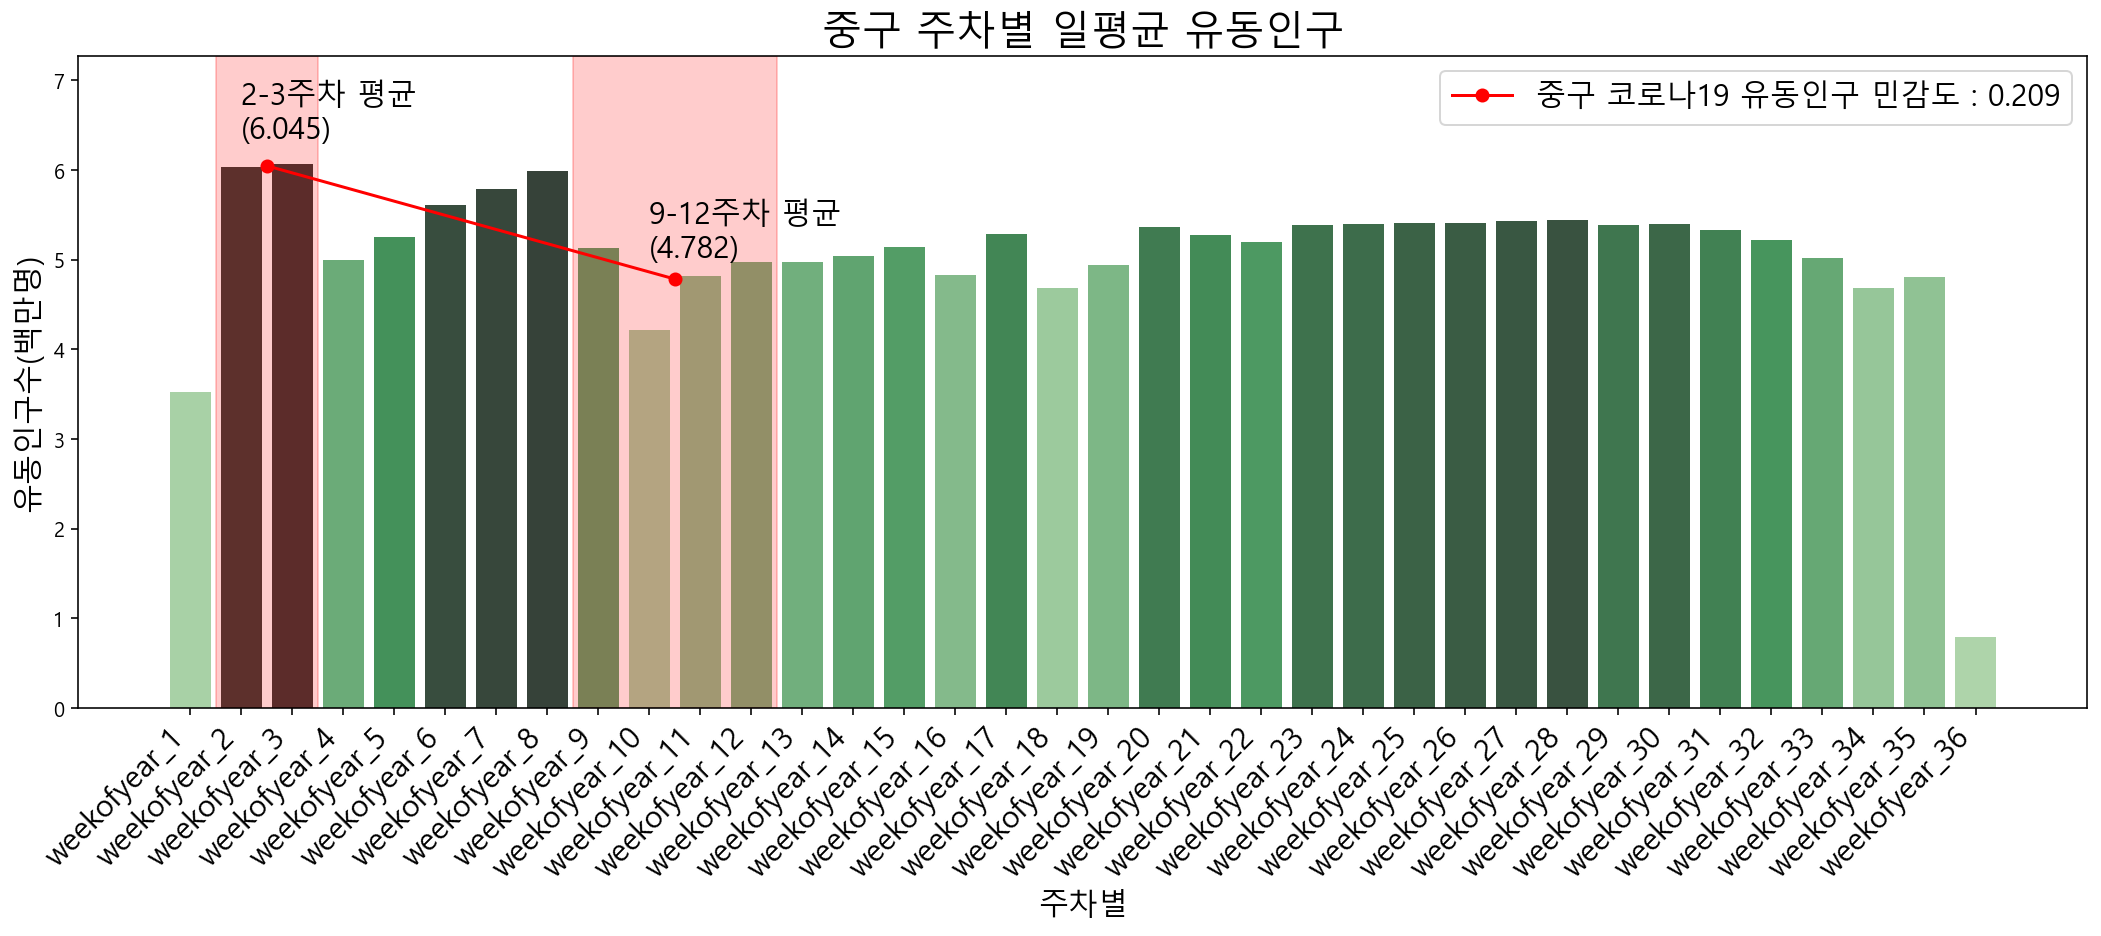

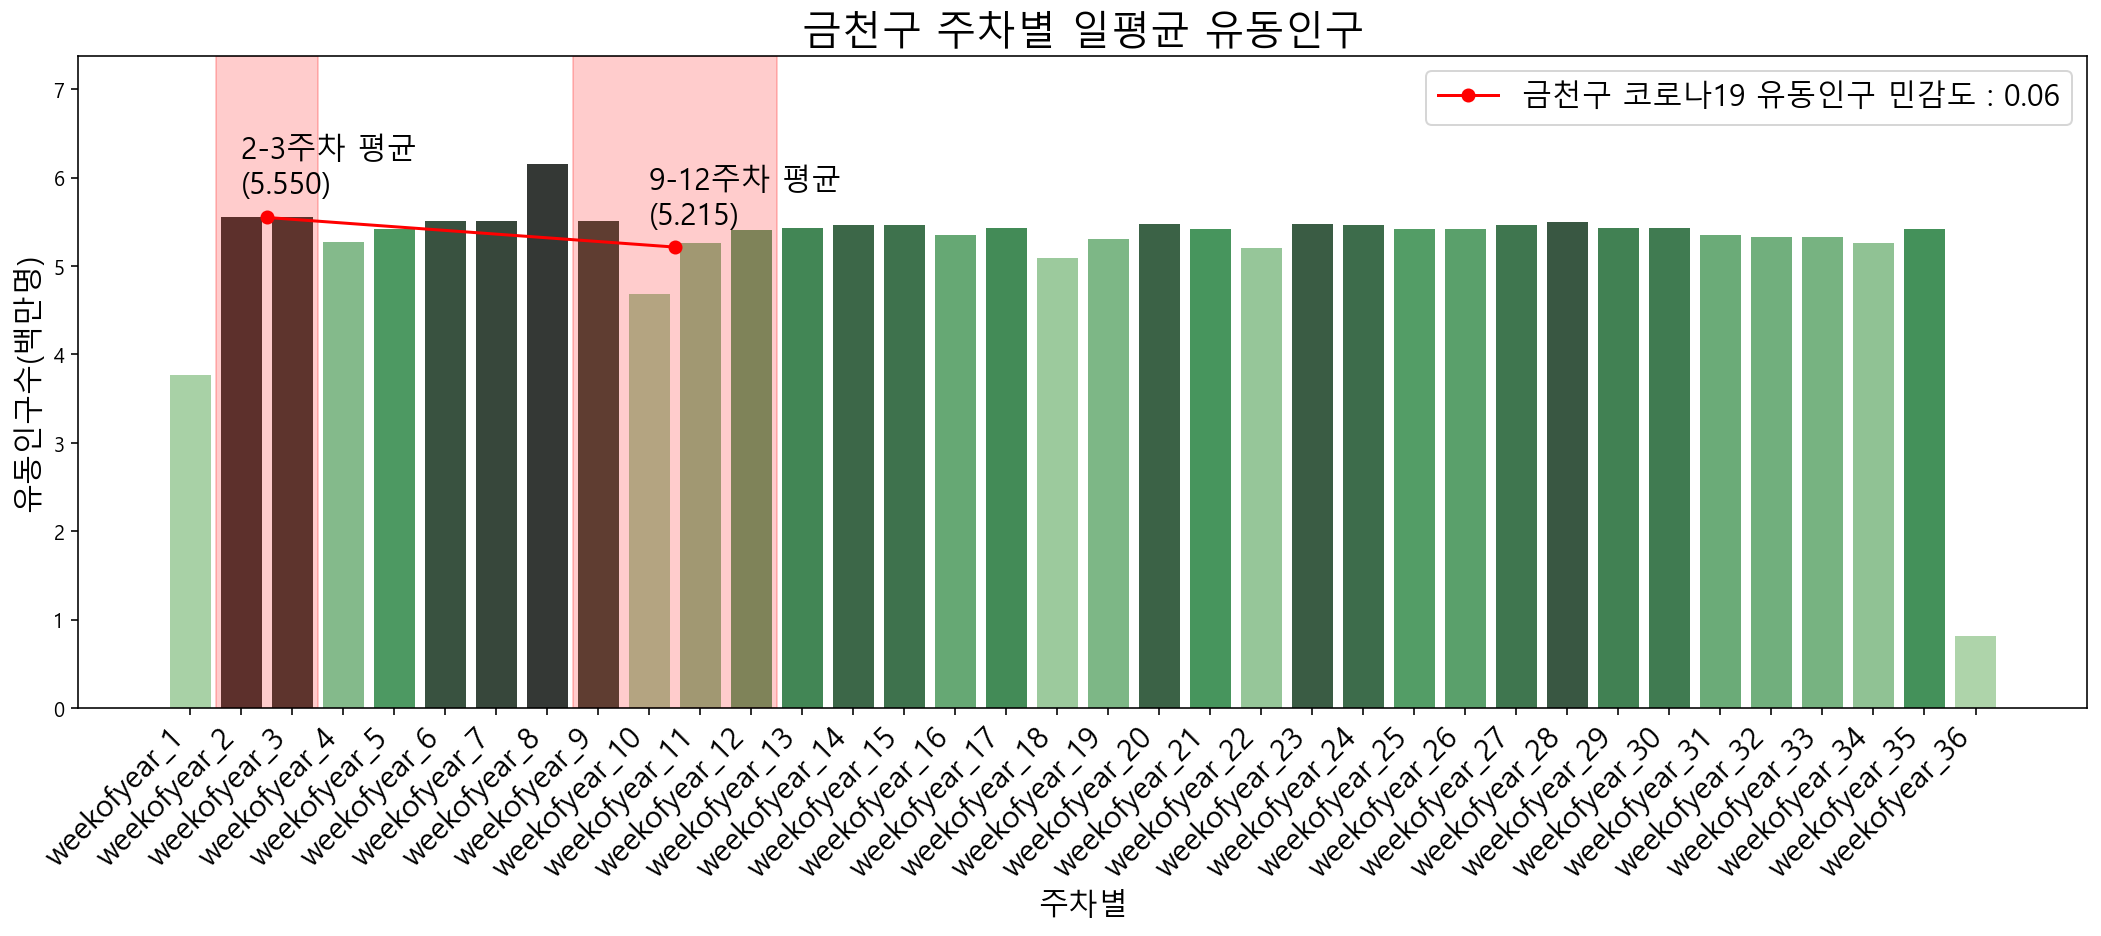

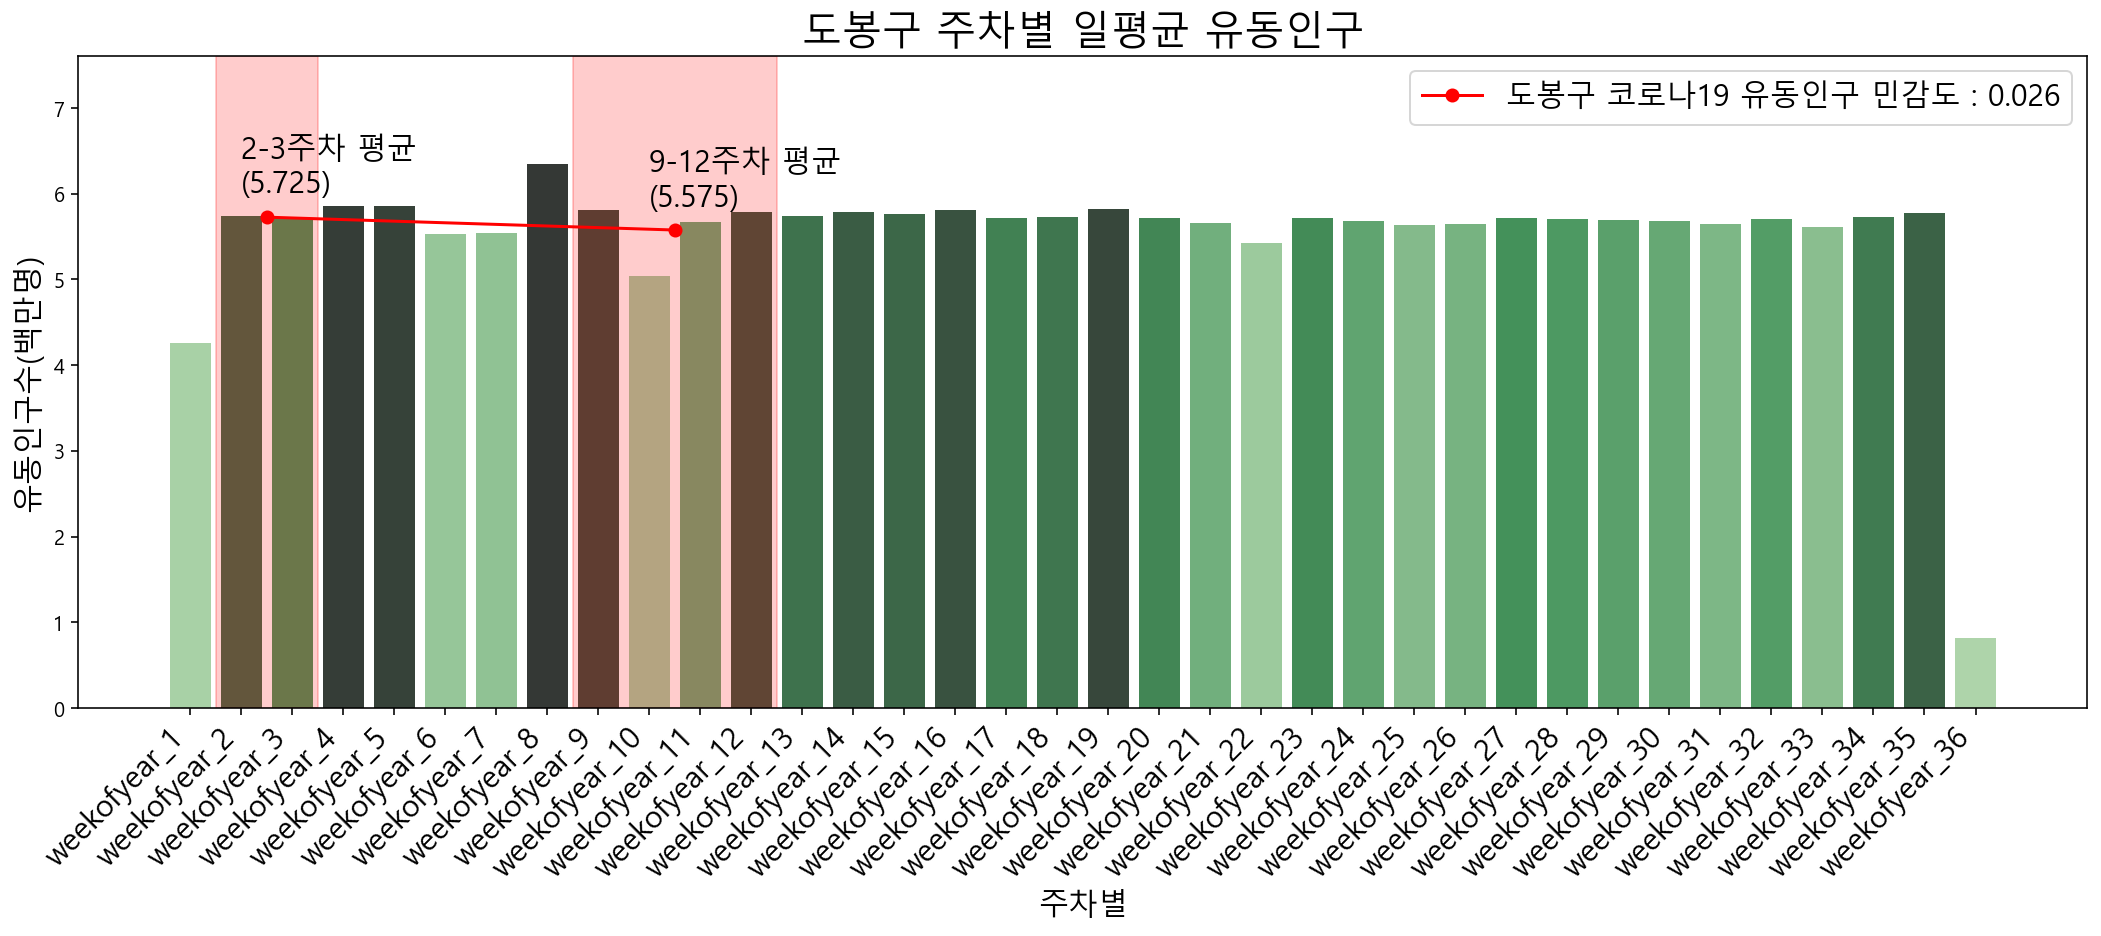

In [93]:
plot_region_fpop(df=timegu, gu_nm='중구')
plot_region_fpop(df=timegu, gu_nm='금천구')
plot_region_fpop(df=timegu, gu_nm='도봉구')

# 구별, 나이별 함수짜기

In [94]:
def plot_region_age_fpop_sensitivity(df, x_axis, rot_x=True, show_xlabel=True):
  plt.figure(figsize=(18, 6))

  pal = sns.color_palette("Oranges_r", df.shape[0])
  rank = df['코로나19_유동인구_민감도'].argsort().argsort()
  sns.barplot(x=x_axis, y='코로나19_유동인구_민감도', data=df, palette=np.array(pal[::-1])[rank])
  plt.axhline(0.15, color='red', alpha=0.5, label='서울시 전체 코로나19 유동인구 민감도')
  for idx, score in enumerate(df.코로나19_유동인구_민감도):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

  plt.title(f'서울시 {x_axis}별 코로나19 유동인구 민감도', size=25)
  plt.legend(fontsize=15)
  plt.ylabel('코로나19 유동인구 민감도', size=15)
  if rot_x:
    plt.xticks(rotation=45, size=15, ha='right')
  if show_xlabel:
    plt.xlabel(x_axis, size=15)
  else:
    plt.xlabel(None)

  plt.show()

In [95]:
k = age_gu.reset_index()
k

,gu,age,week,ppl
0,강남구,20,1,1.90
1,강남구,20,2,2.98
2,강남구,20,3,2.99
3,강남구,20,4,2.46
4,강남구,20,5,2.71
...,...,...,...,...
5395,중랑구,70,32,0.75
5396,중랑구,70,33,0.74
5397,중랑구,70,34,0.74
5398,중랑구,70,35,0.74


In [96]:
gu_list = list(k.loc[:]['gu'].unique())

In [97]:
for gu in gu_list:
    k[k.loc[:]['gu']==gu]

강남구의 연령별 코로나 유동인구 민감도


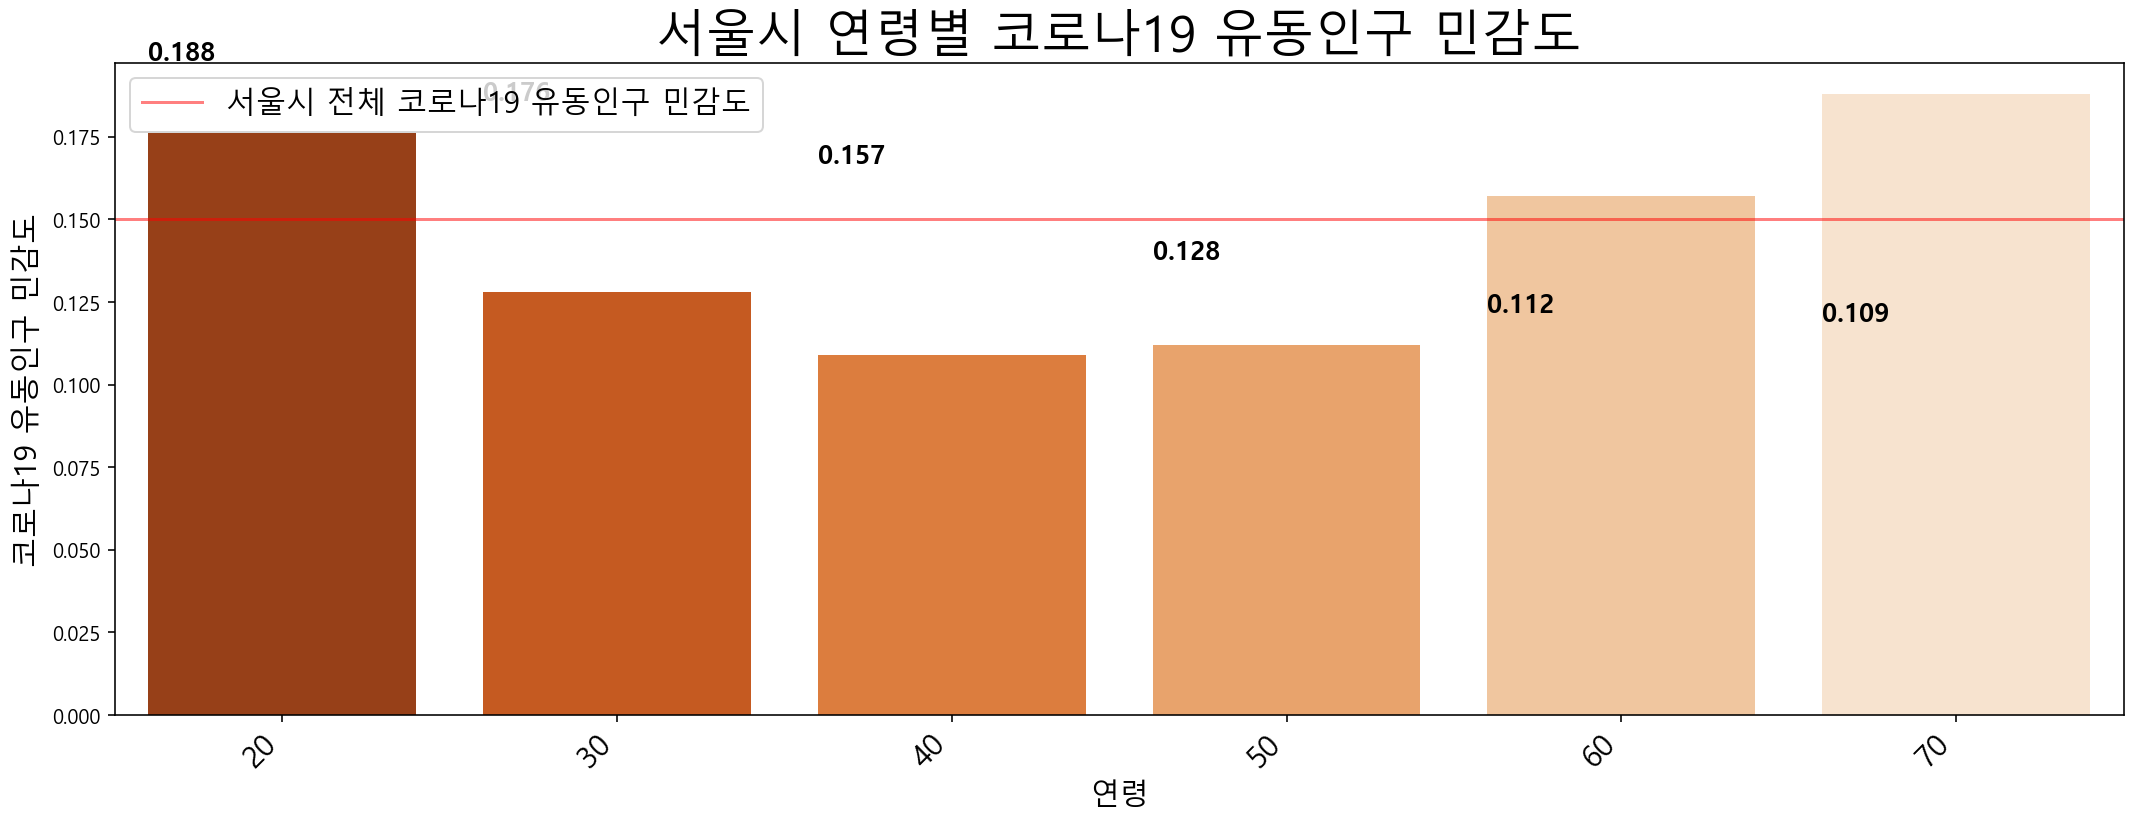

강동구의 연령별 코로나 유동인구 민감도


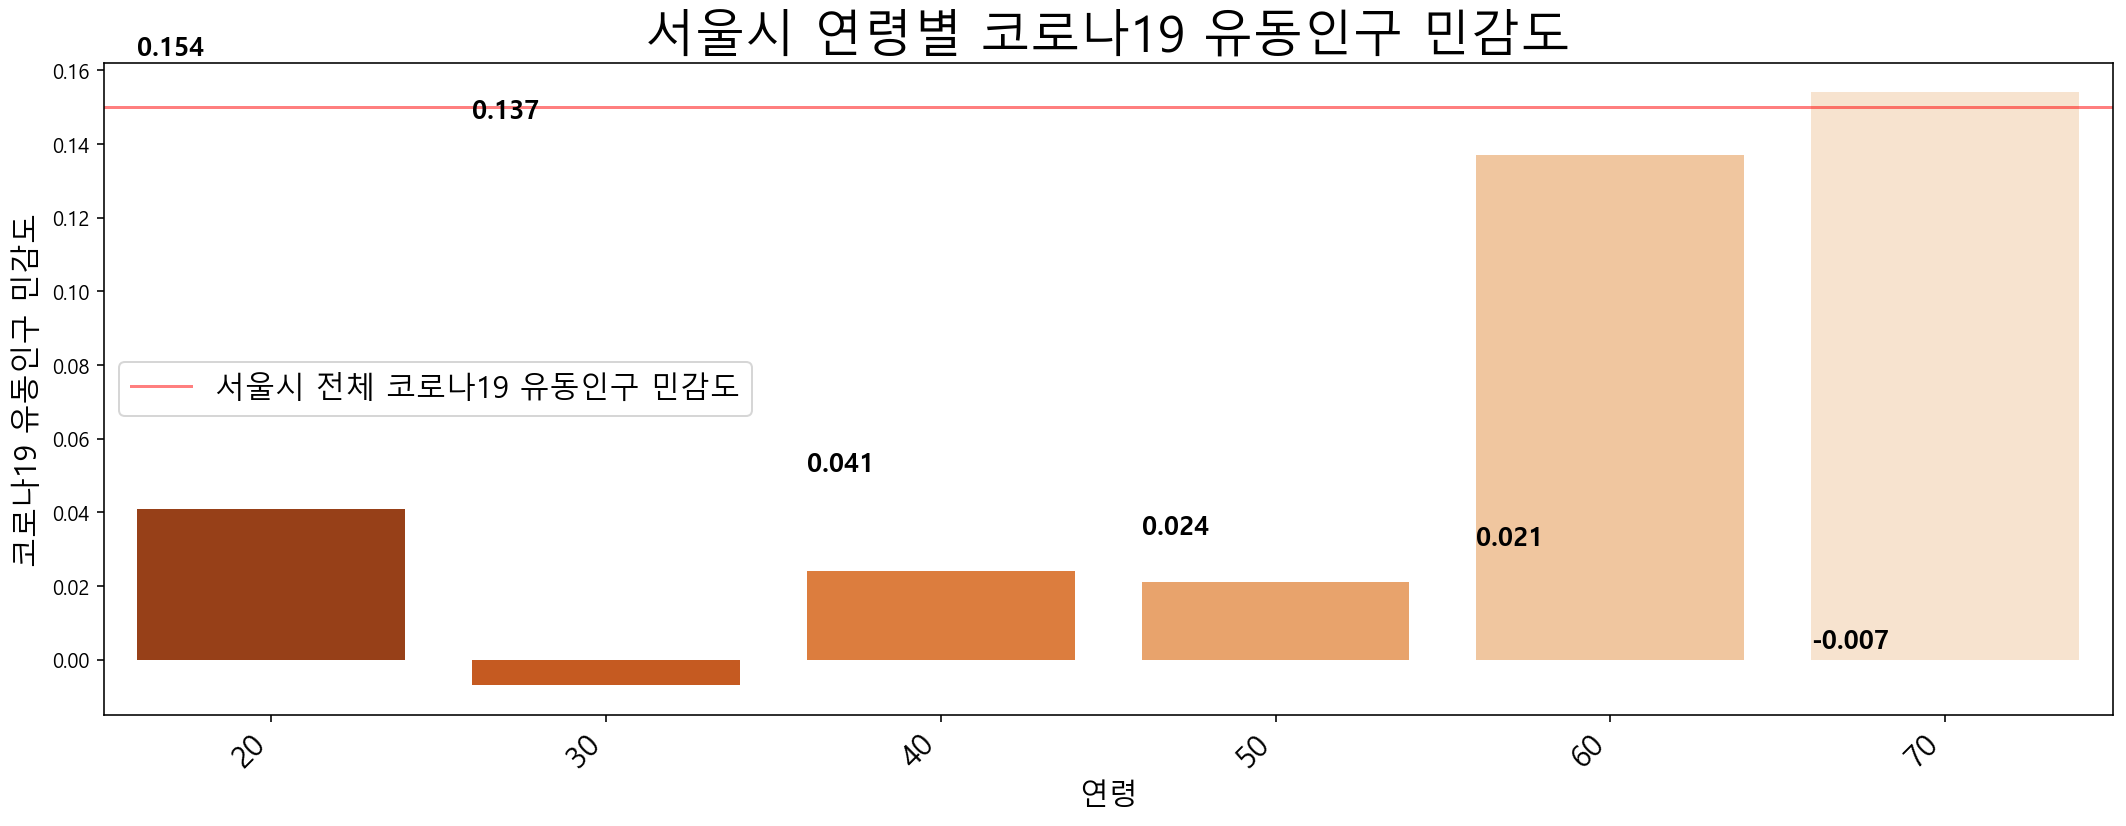

강북구의 연령별 코로나 유동인구 민감도


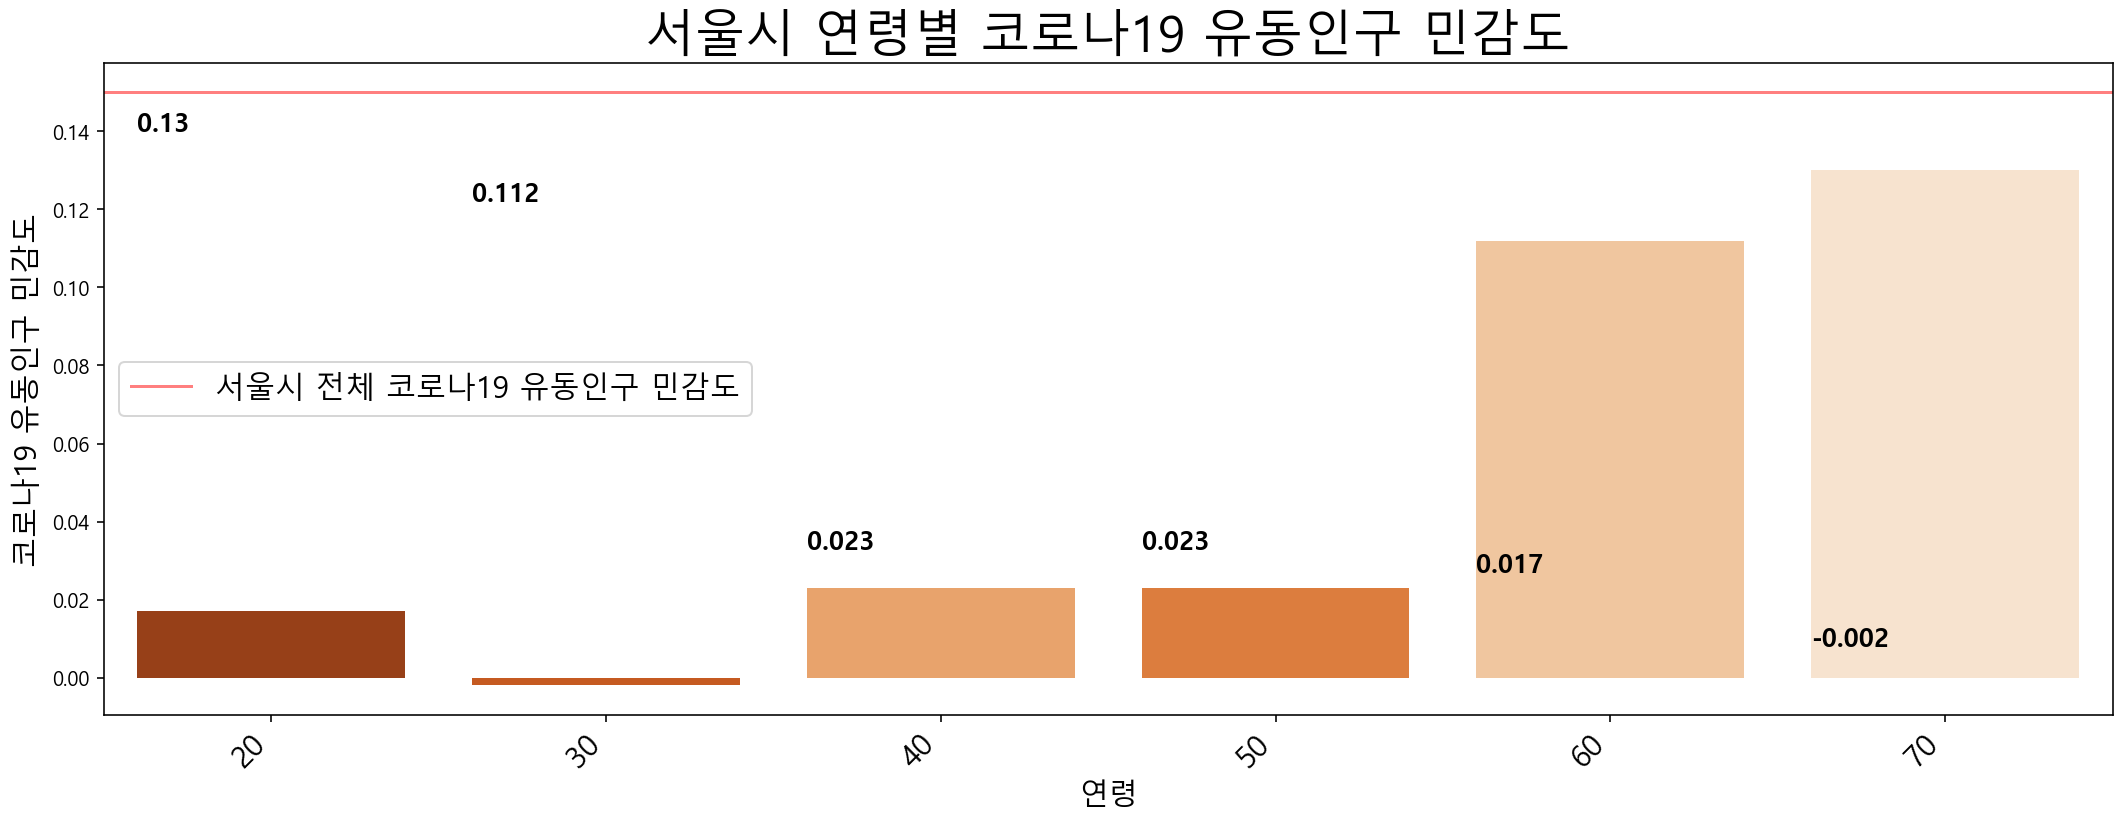

강서구의 연령별 코로나 유동인구 민감도


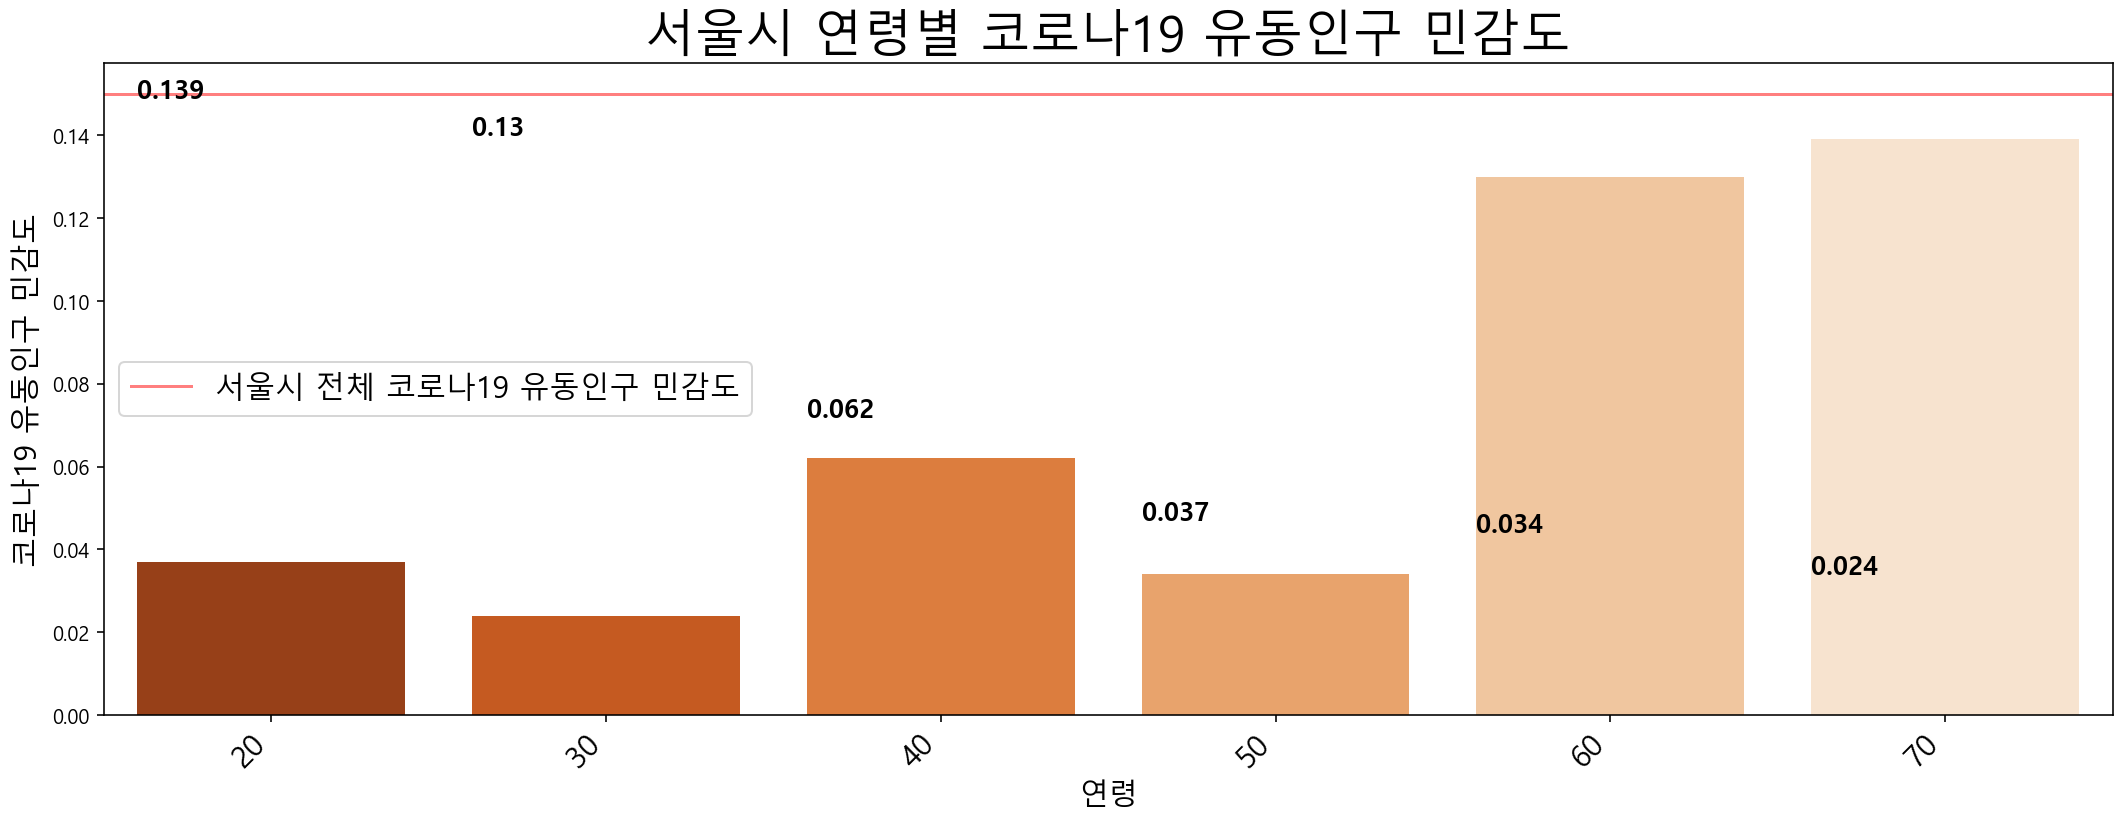

관악구의 연령별 코로나 유동인구 민감도


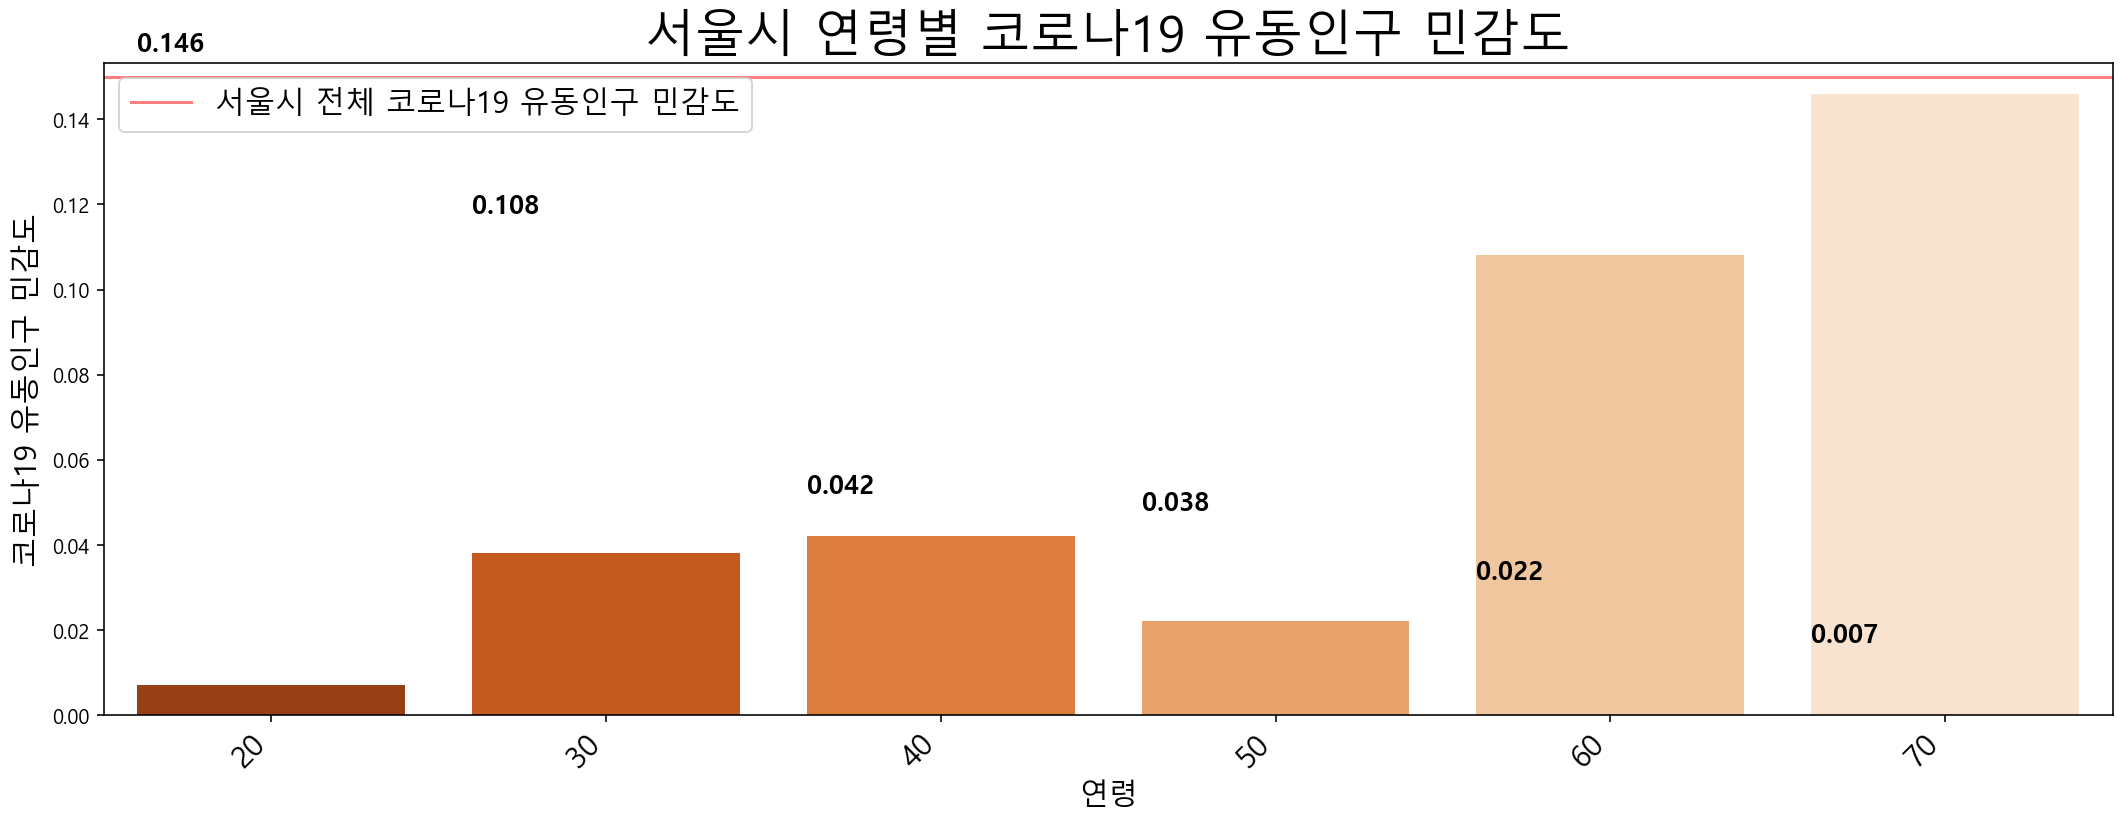

광진구의 연령별 코로나 유동인구 민감도


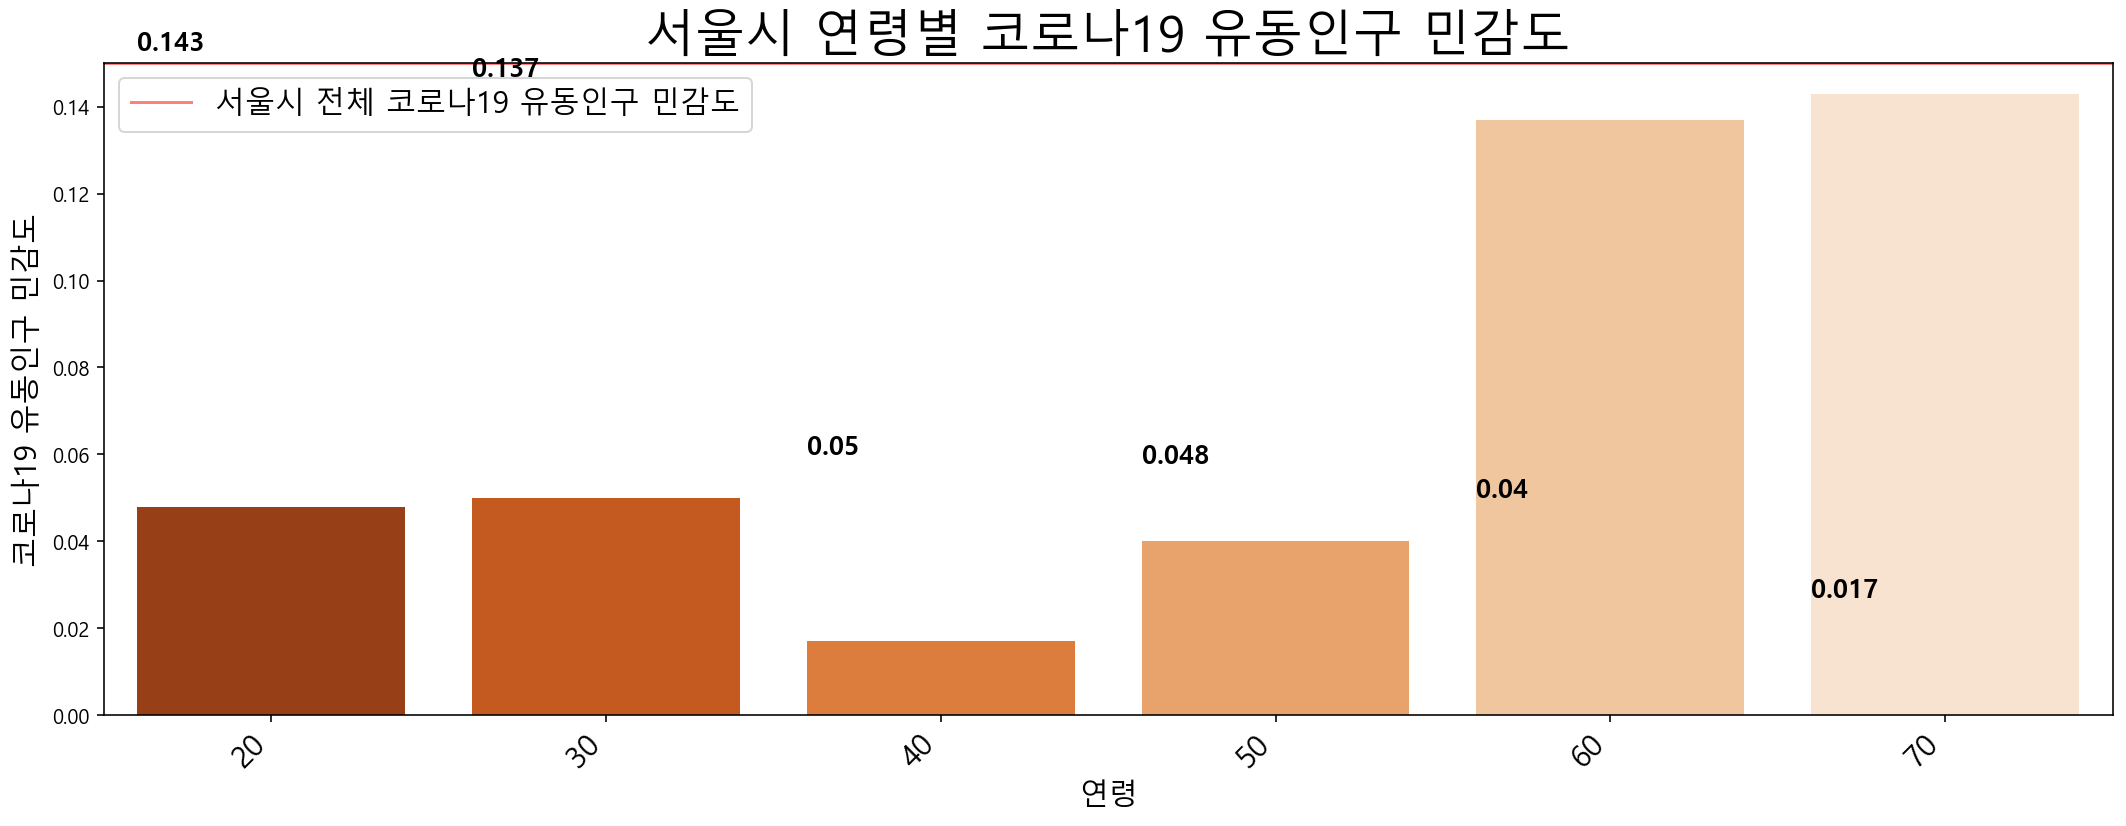

구로구의 연령별 코로나 유동인구 민감도


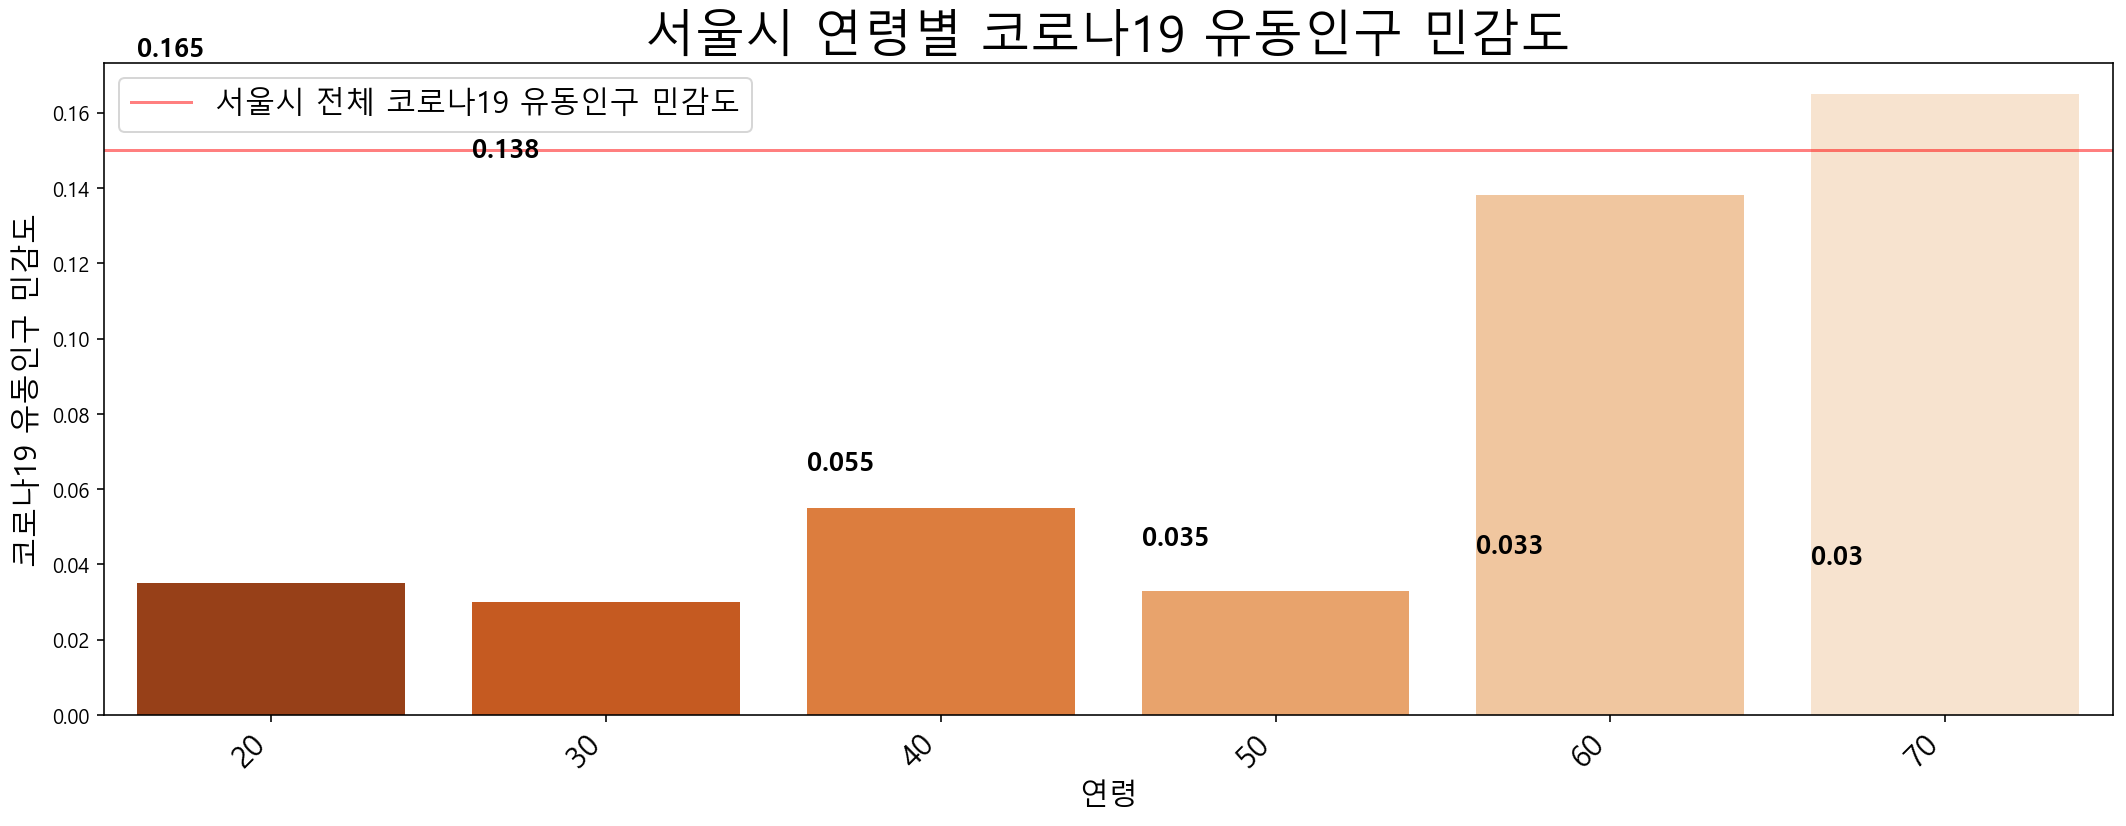

금천구의 연령별 코로나 유동인구 민감도


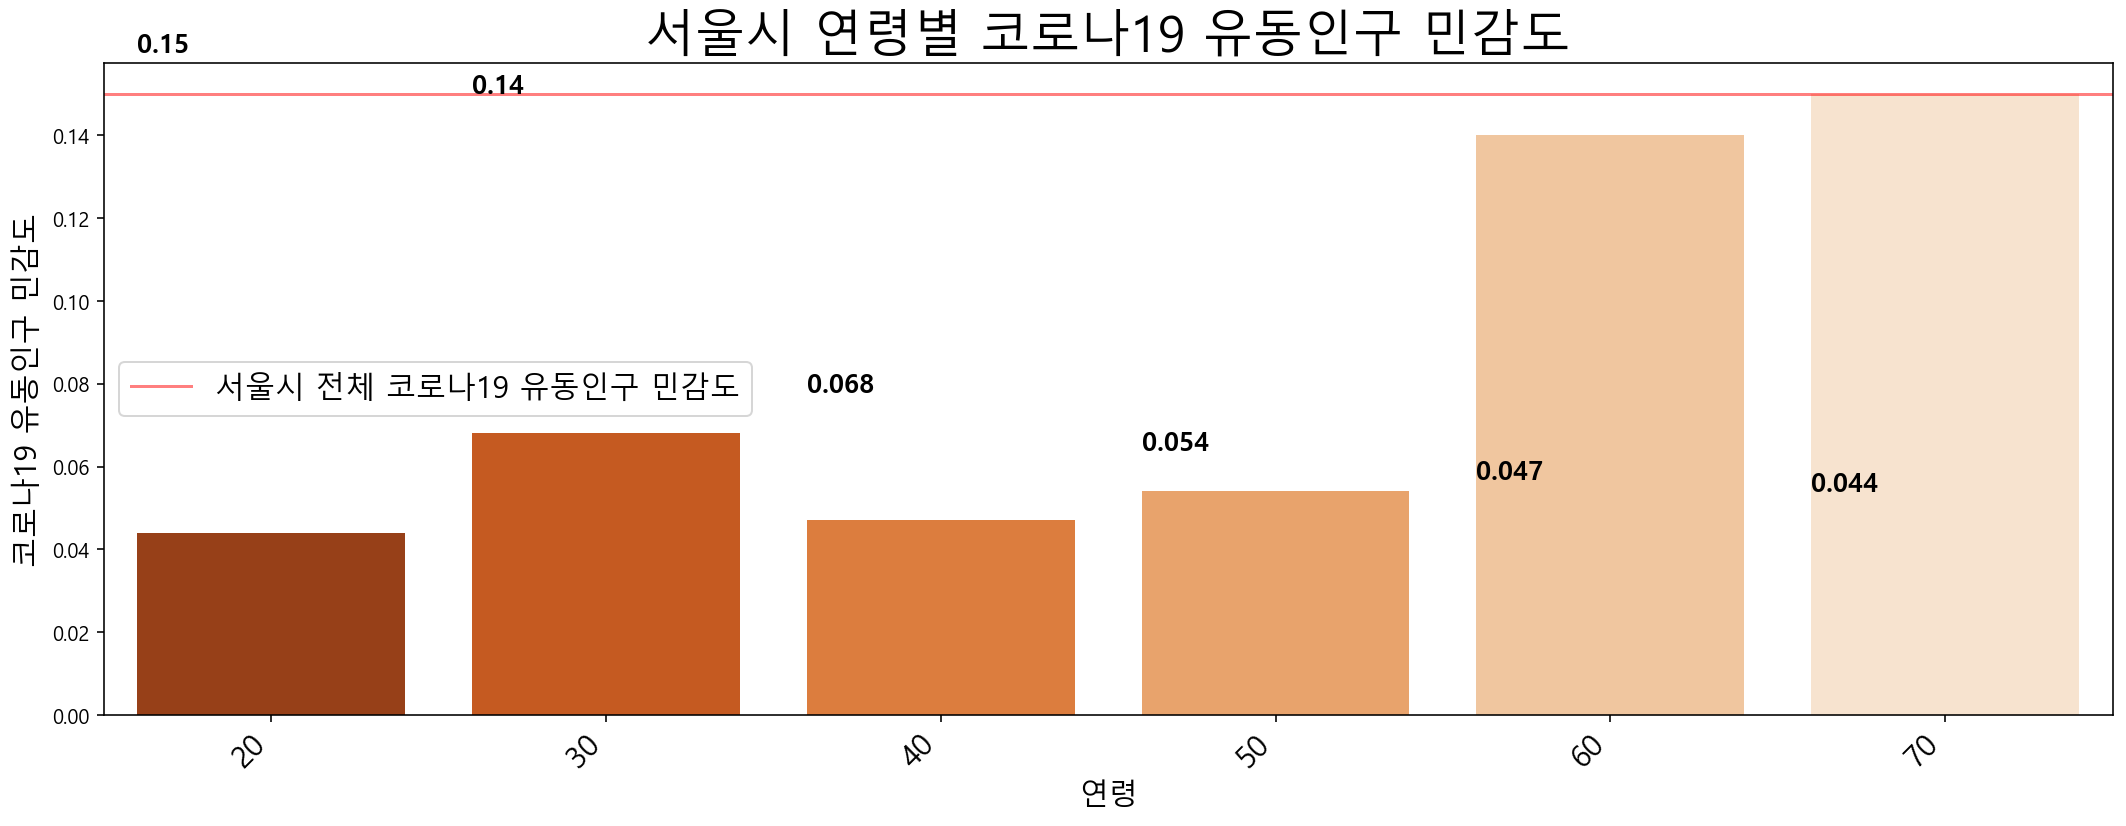

노원구의 연령별 코로나 유동인구 민감도


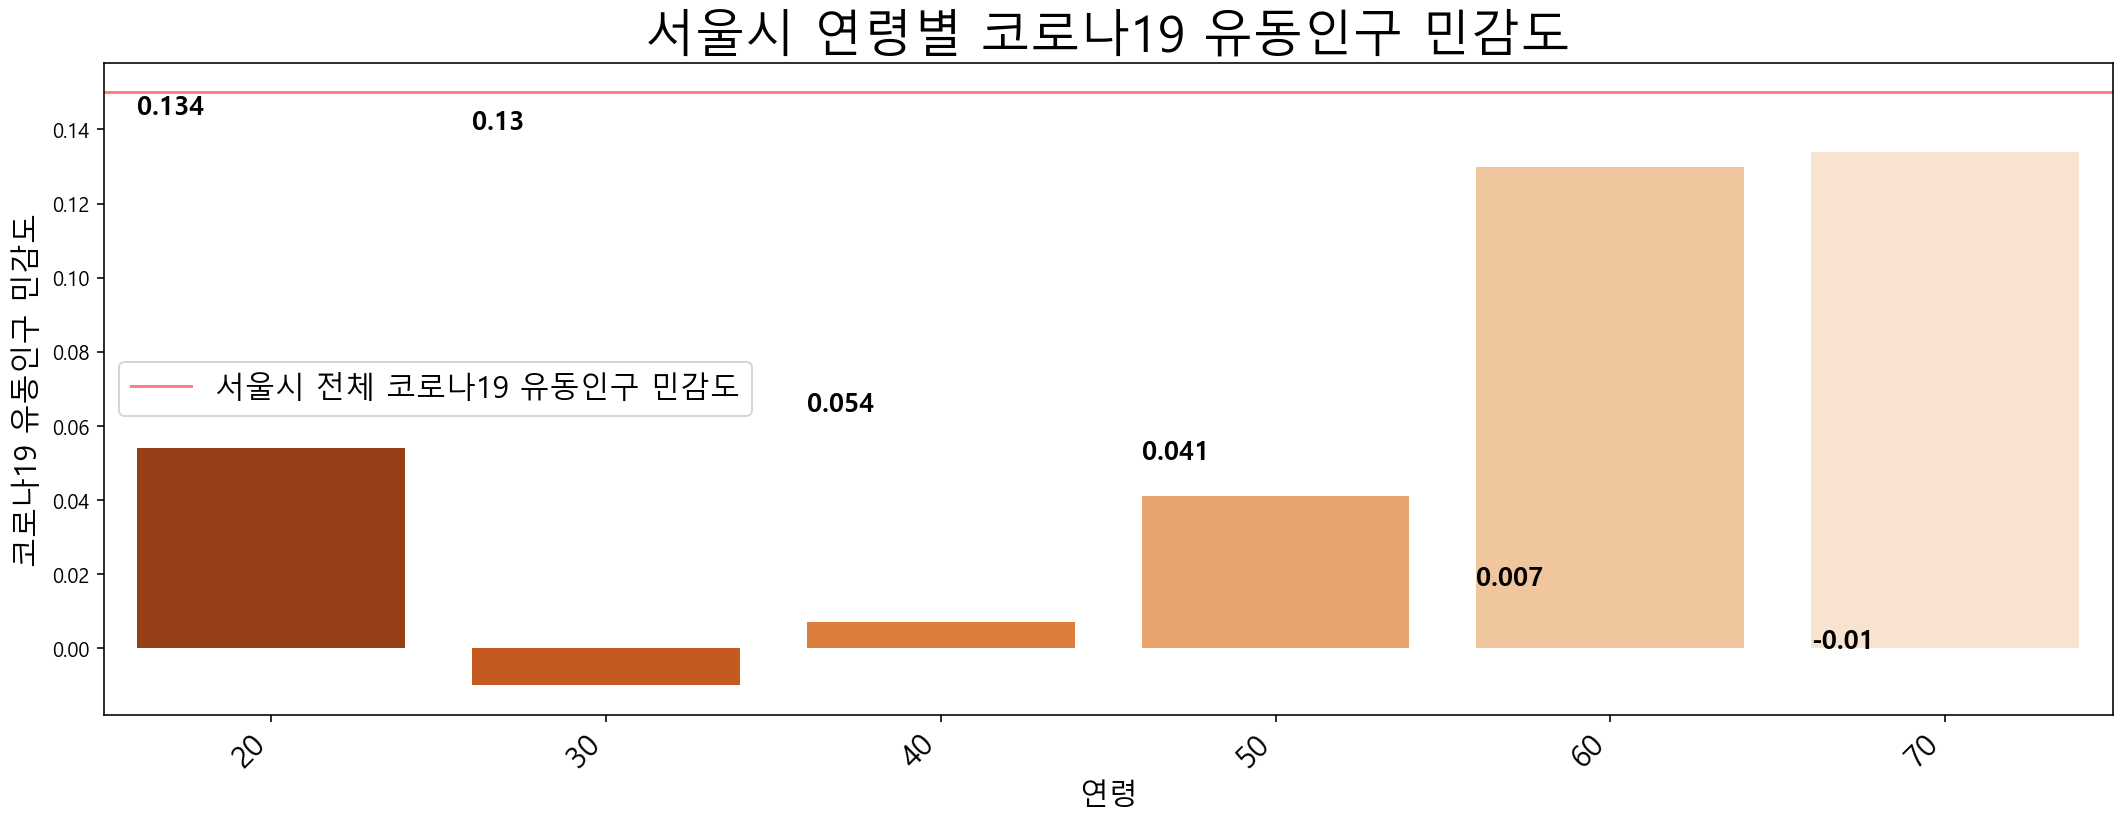

도봉구의 연령별 코로나 유동인구 민감도


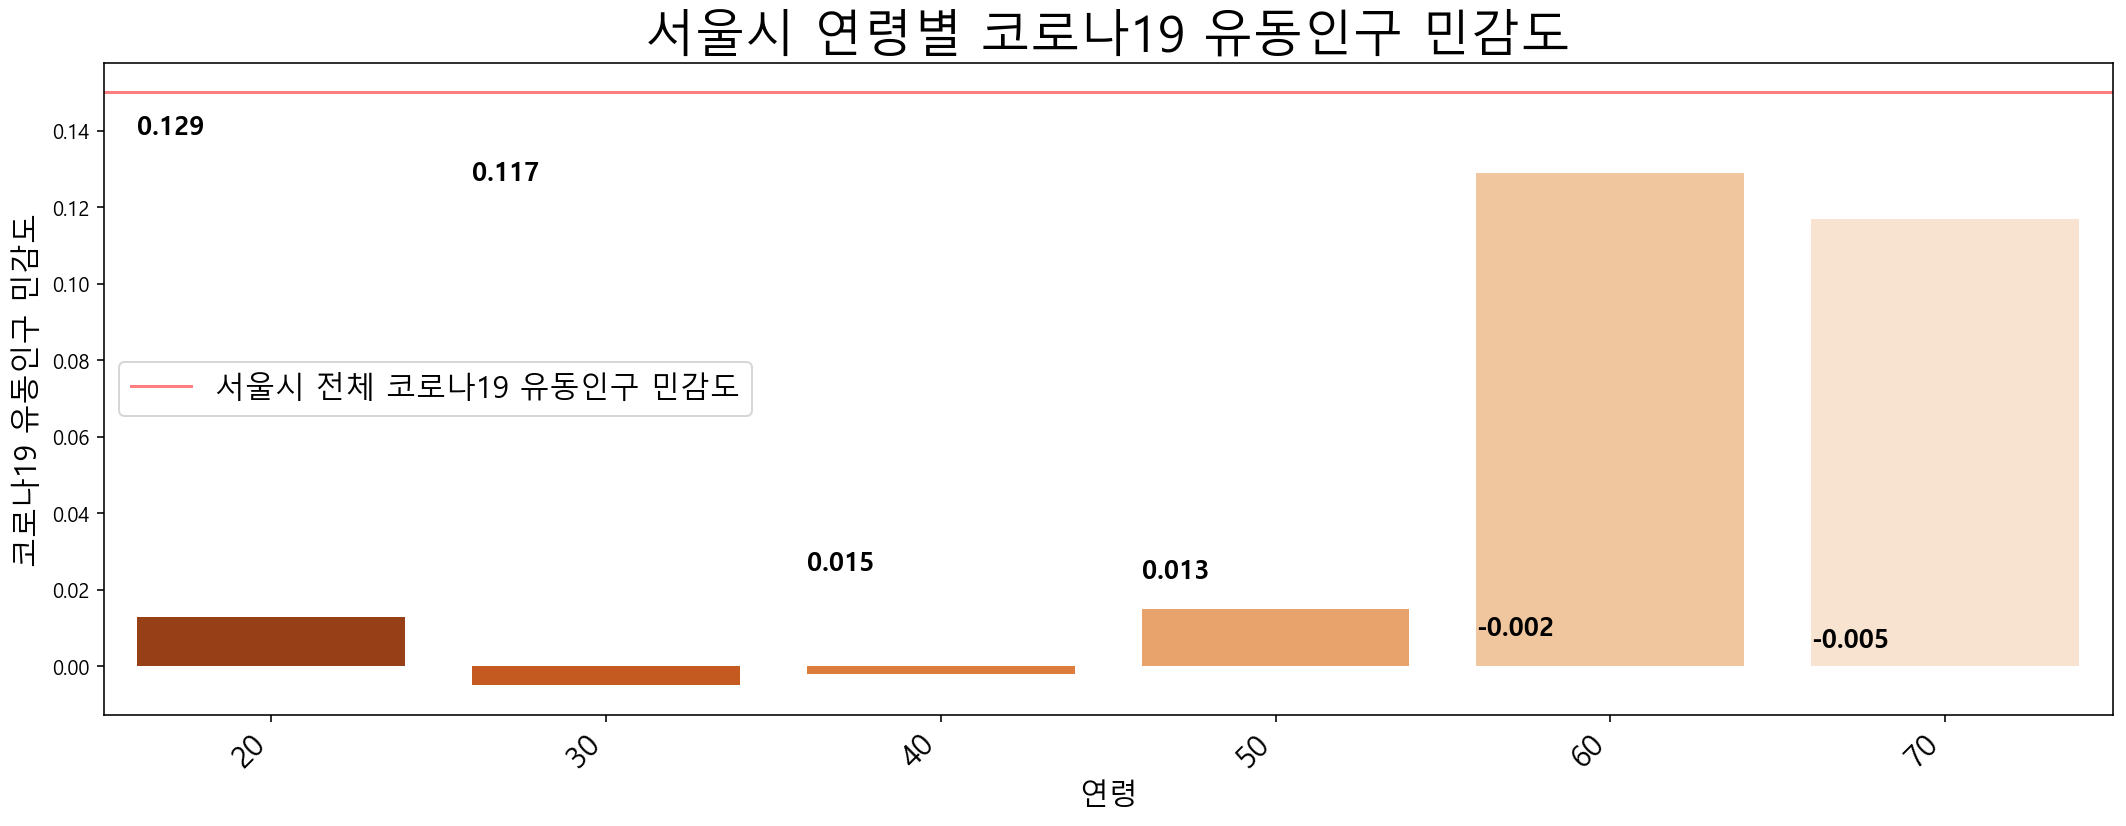

동대문구의 연령별 코로나 유동인구 민감도


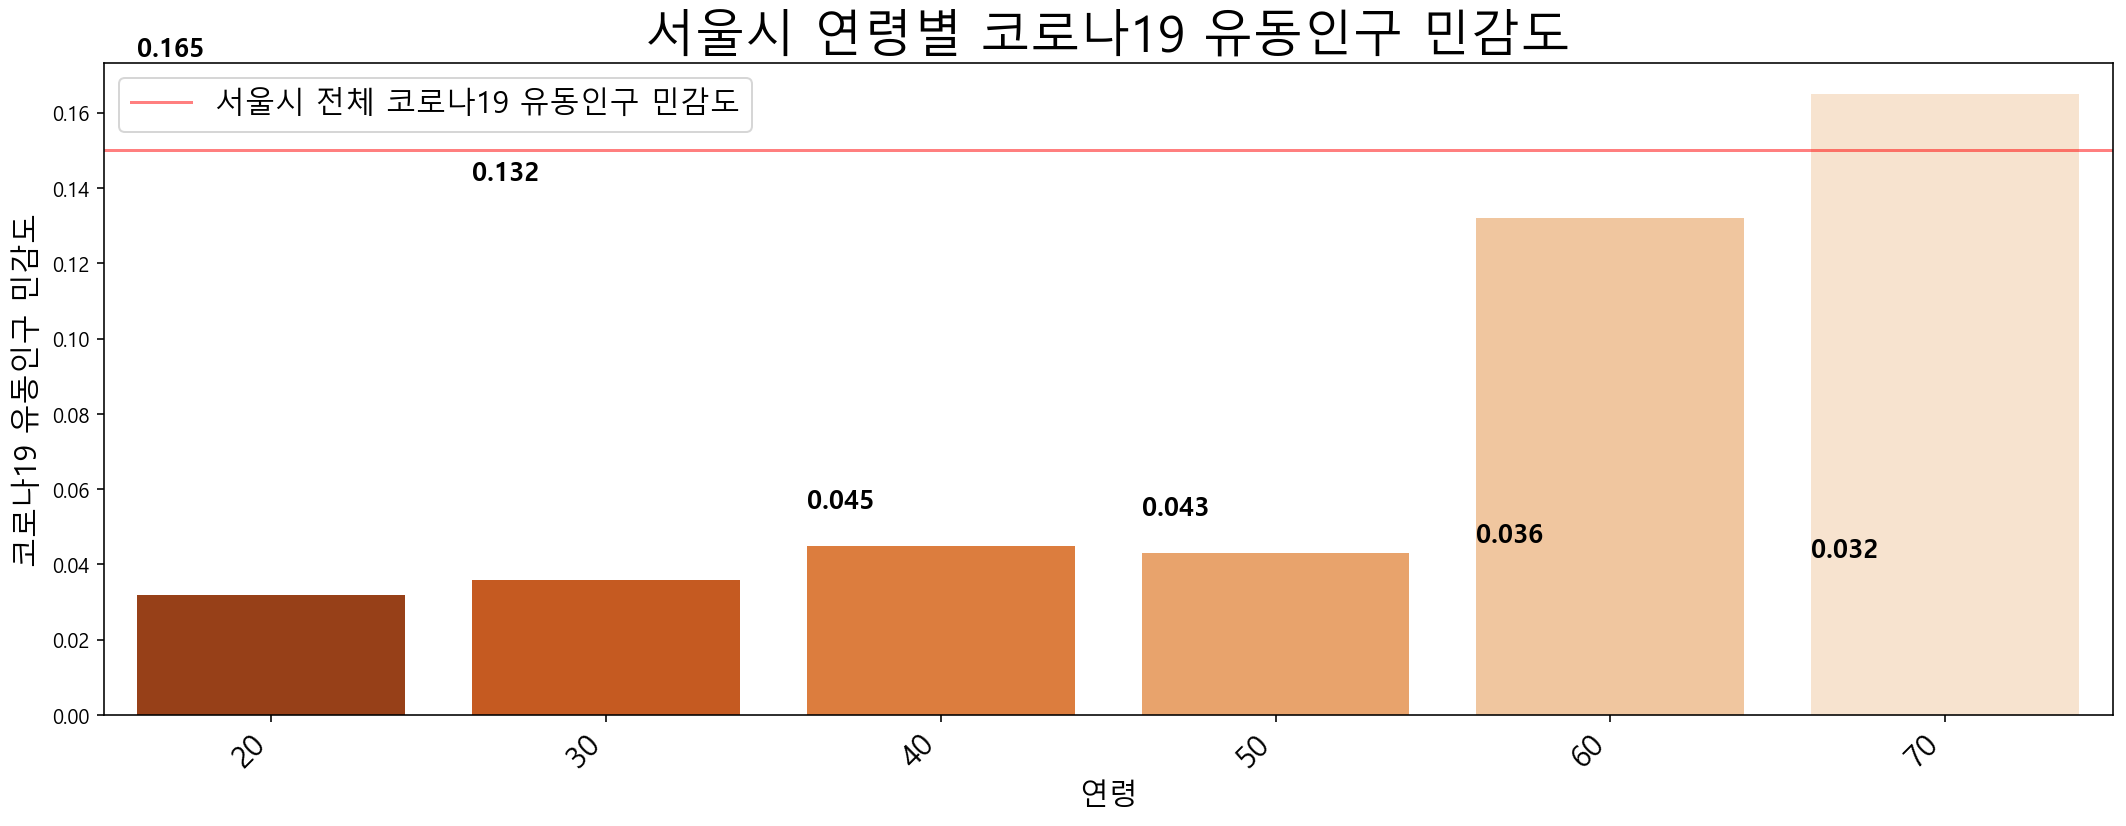

동작구의 연령별 코로나 유동인구 민감도


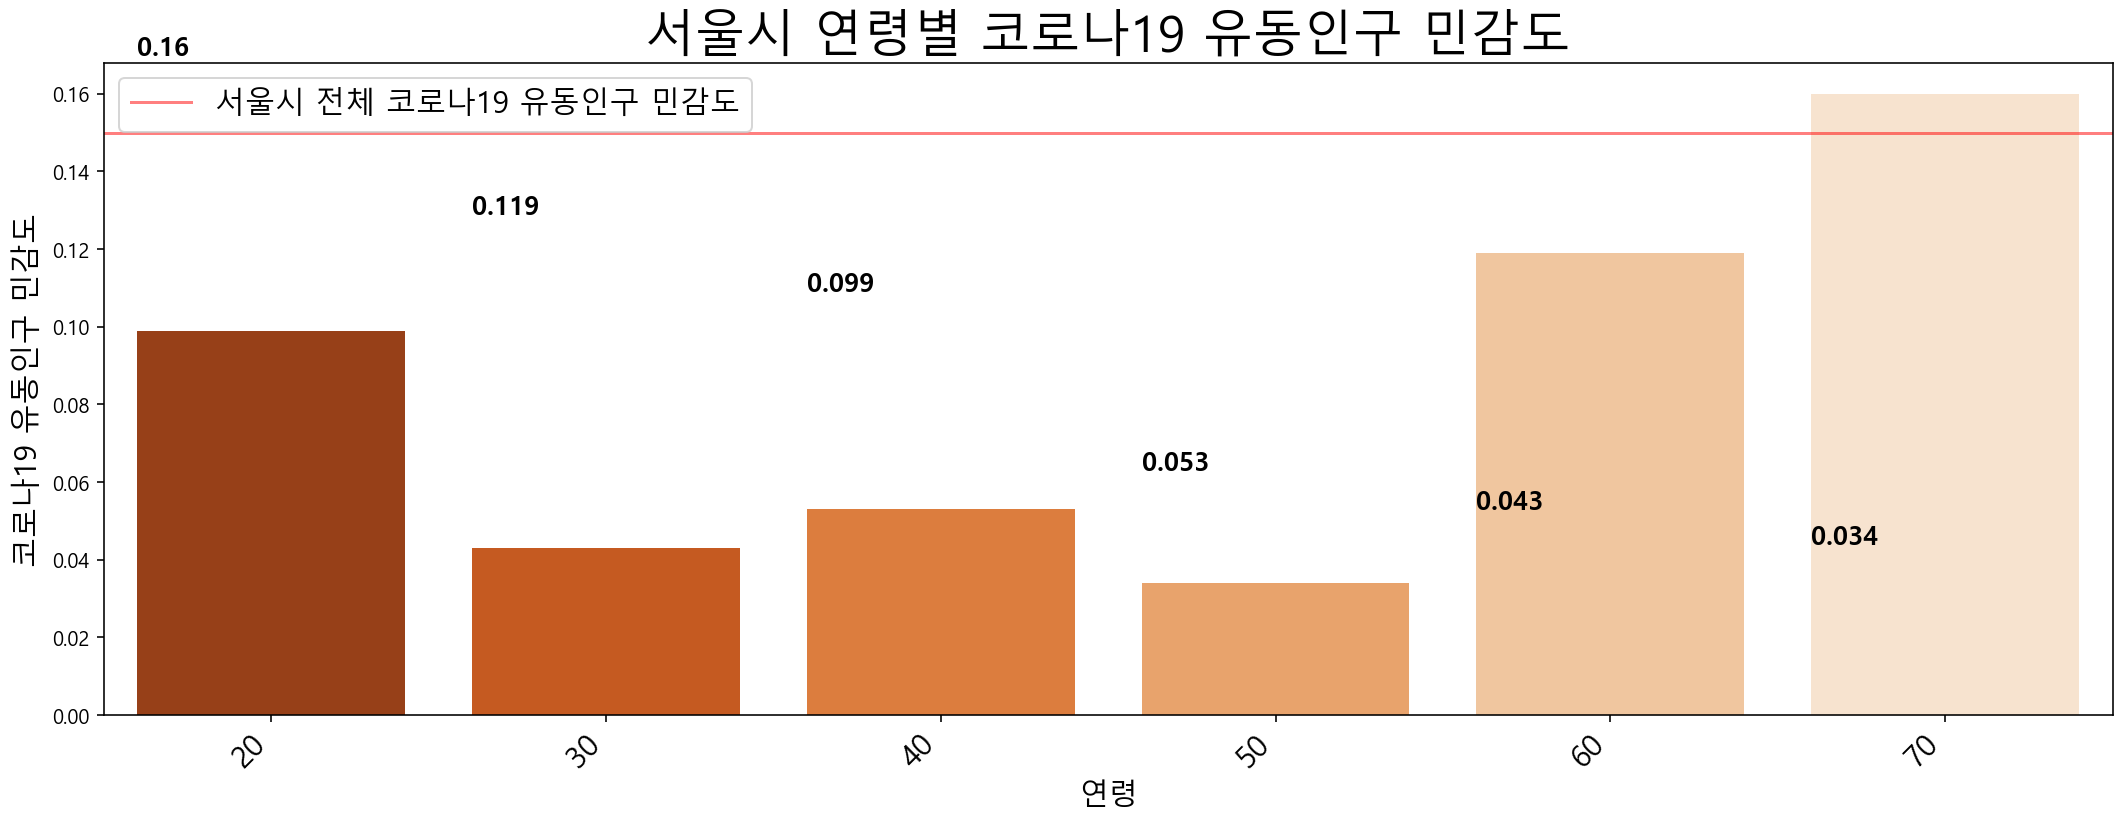

마포구의 연령별 코로나 유동인구 민감도


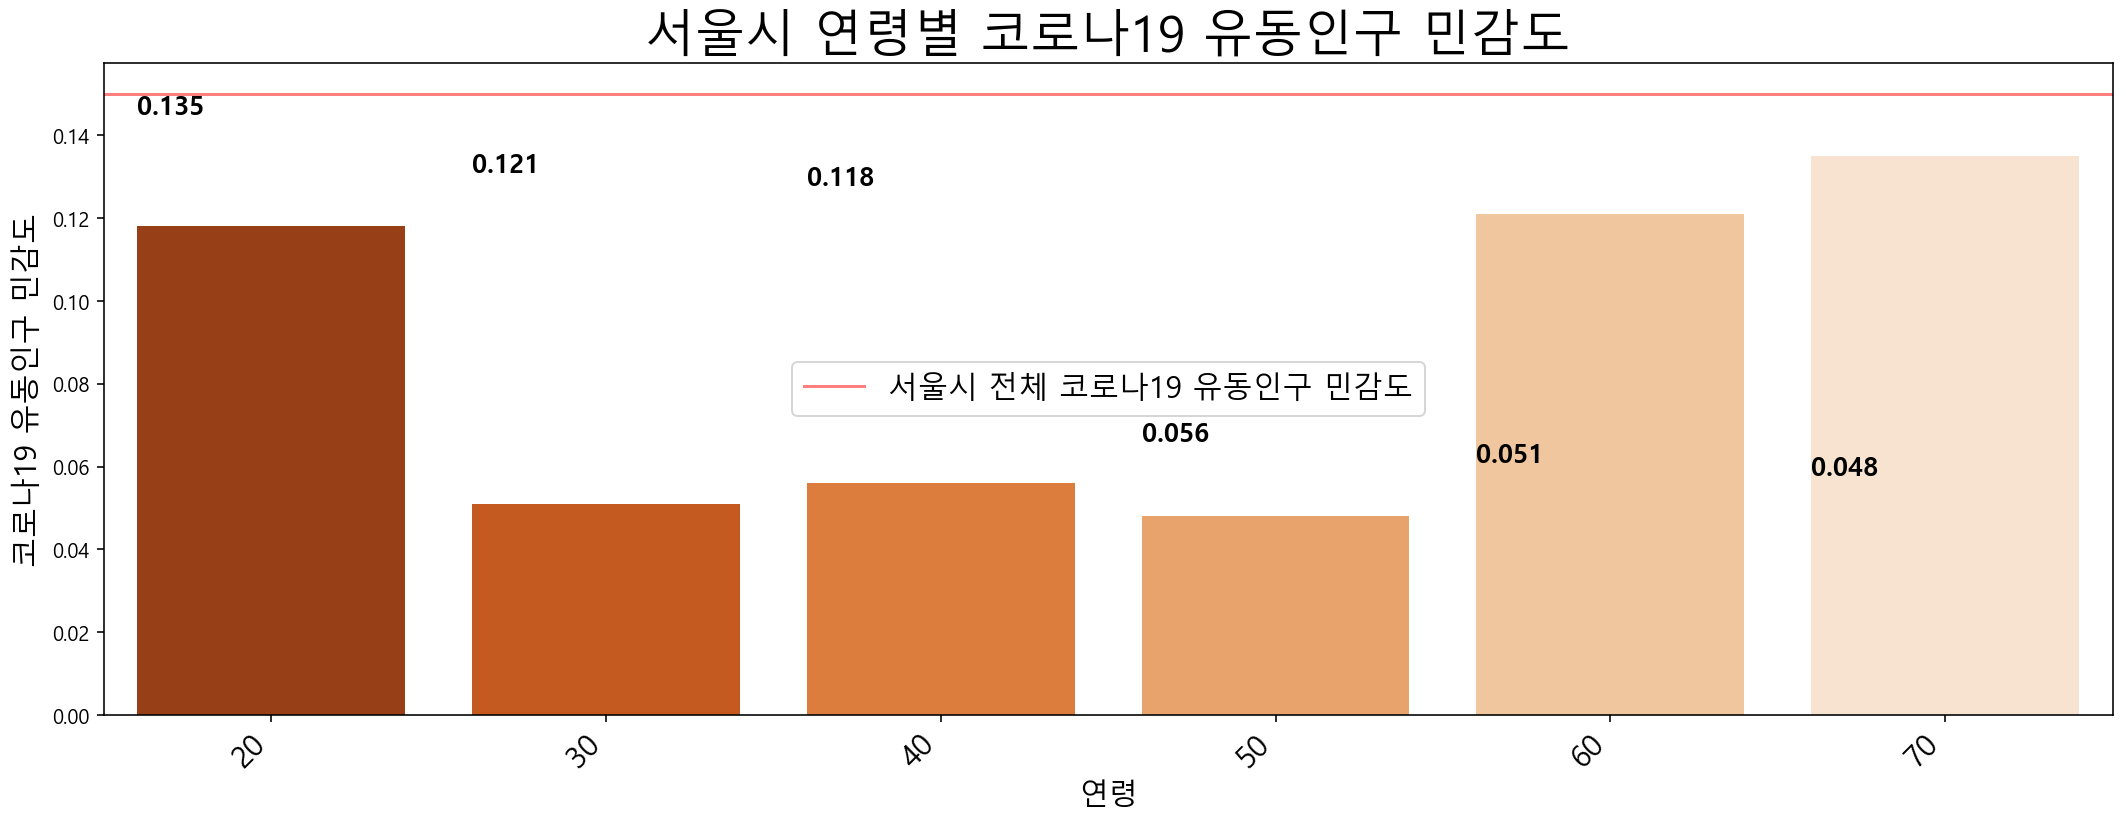

서대문구의 연령별 코로나 유동인구 민감도


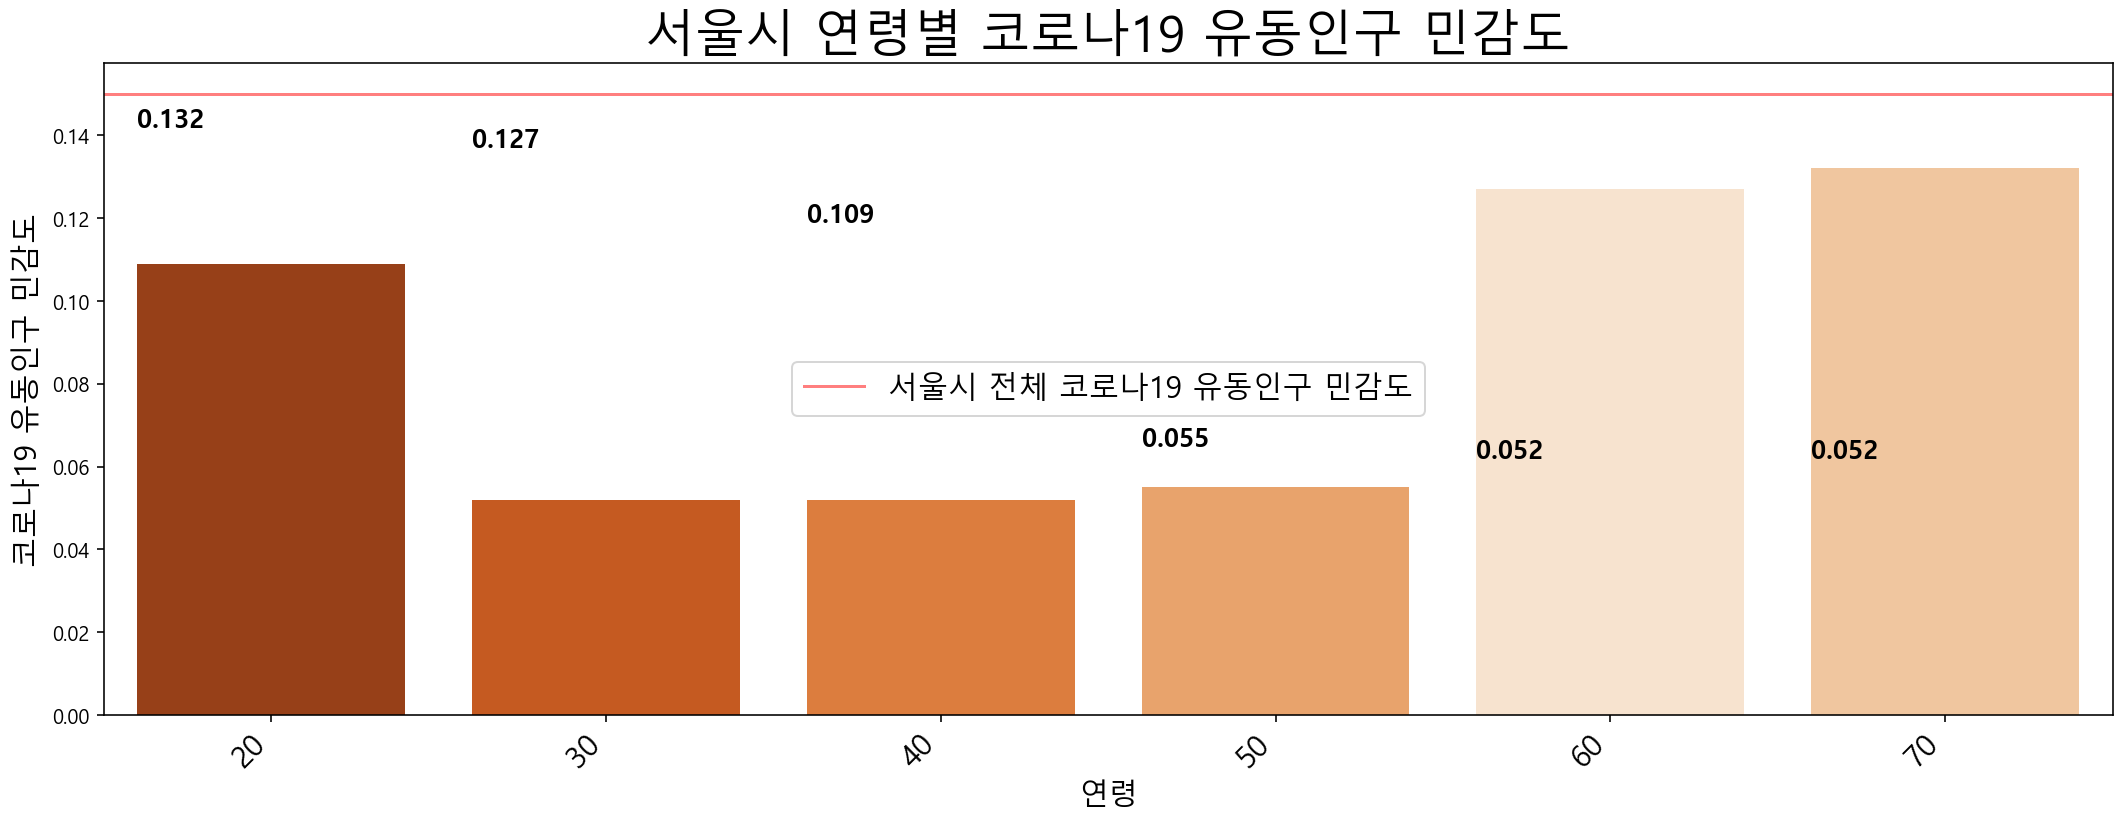

서초구의 연령별 코로나 유동인구 민감도


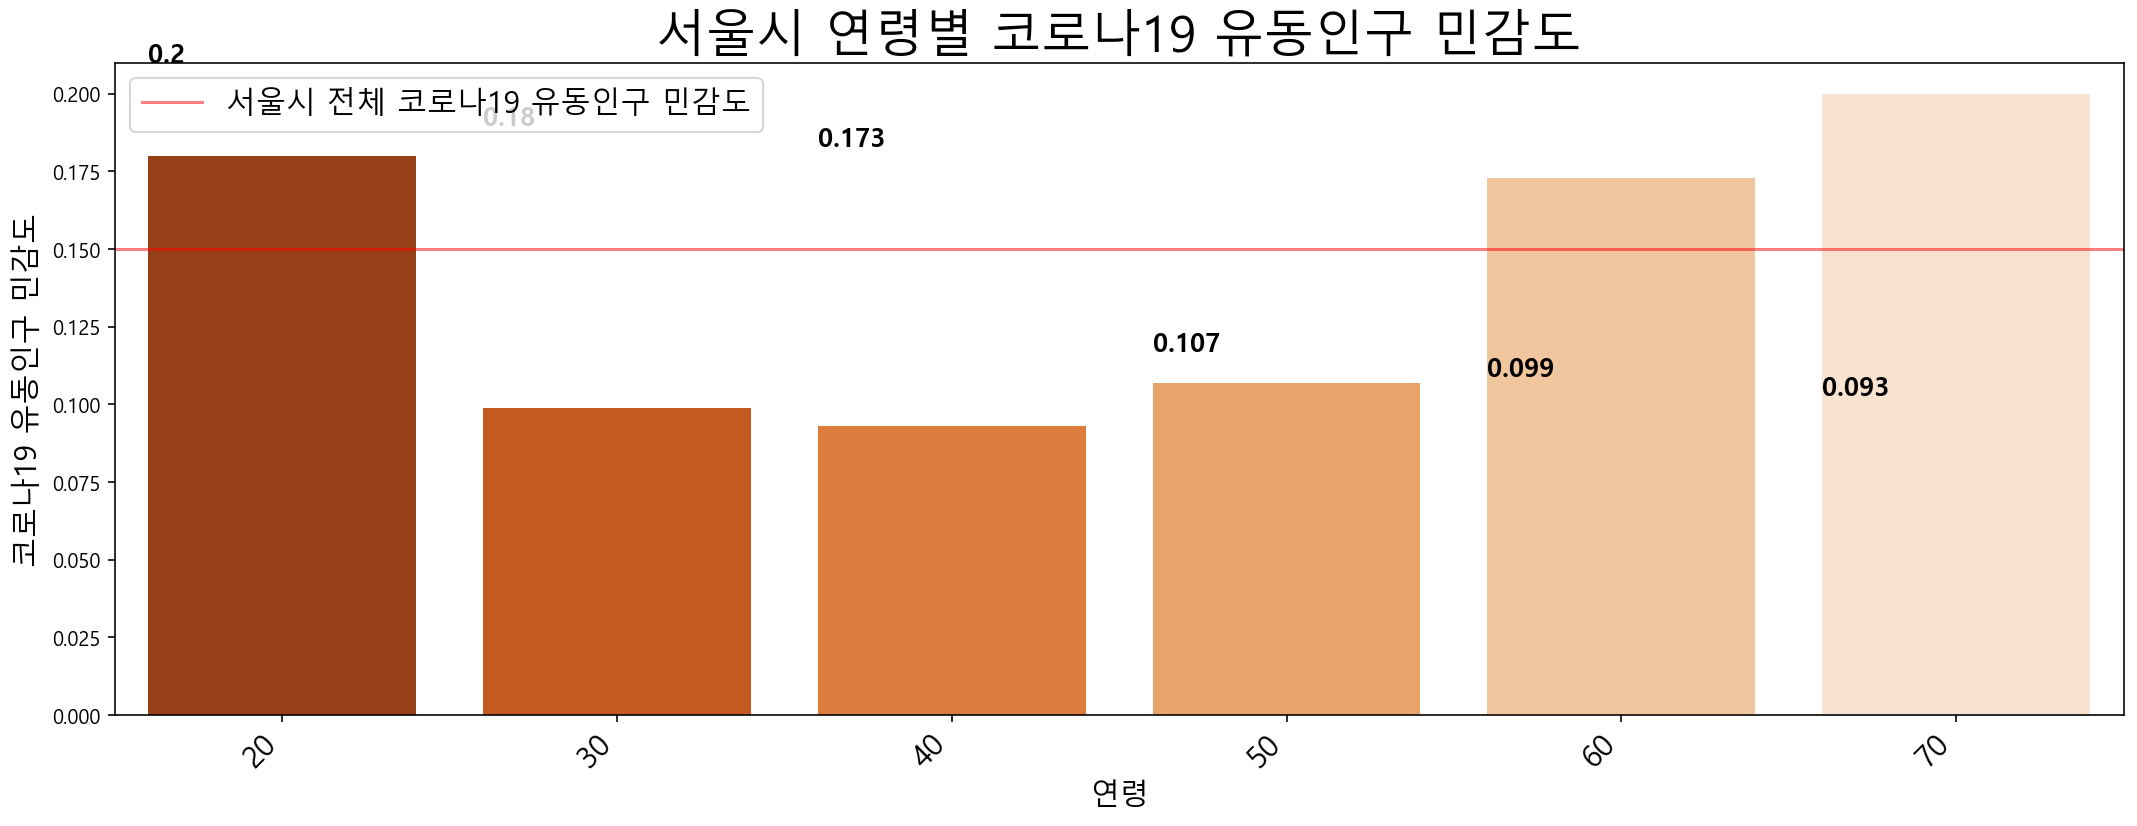

성동구의 연령별 코로나 유동인구 민감도


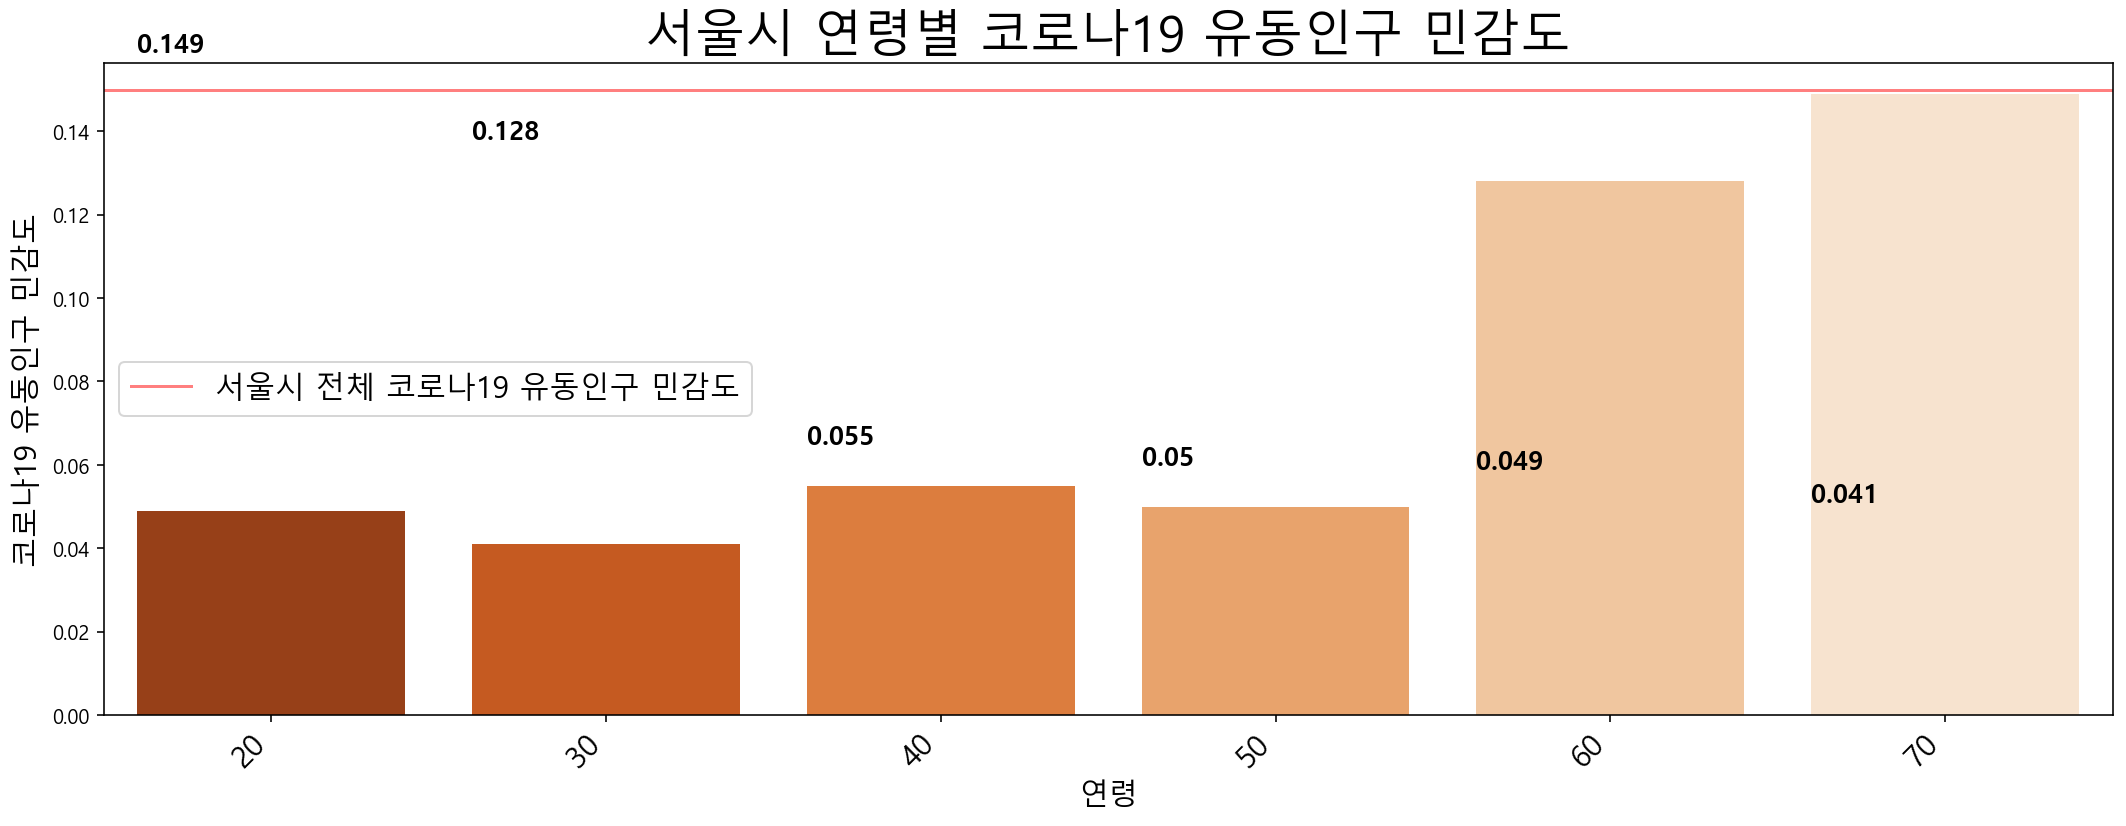

성북구의 연령별 코로나 유동인구 민감도


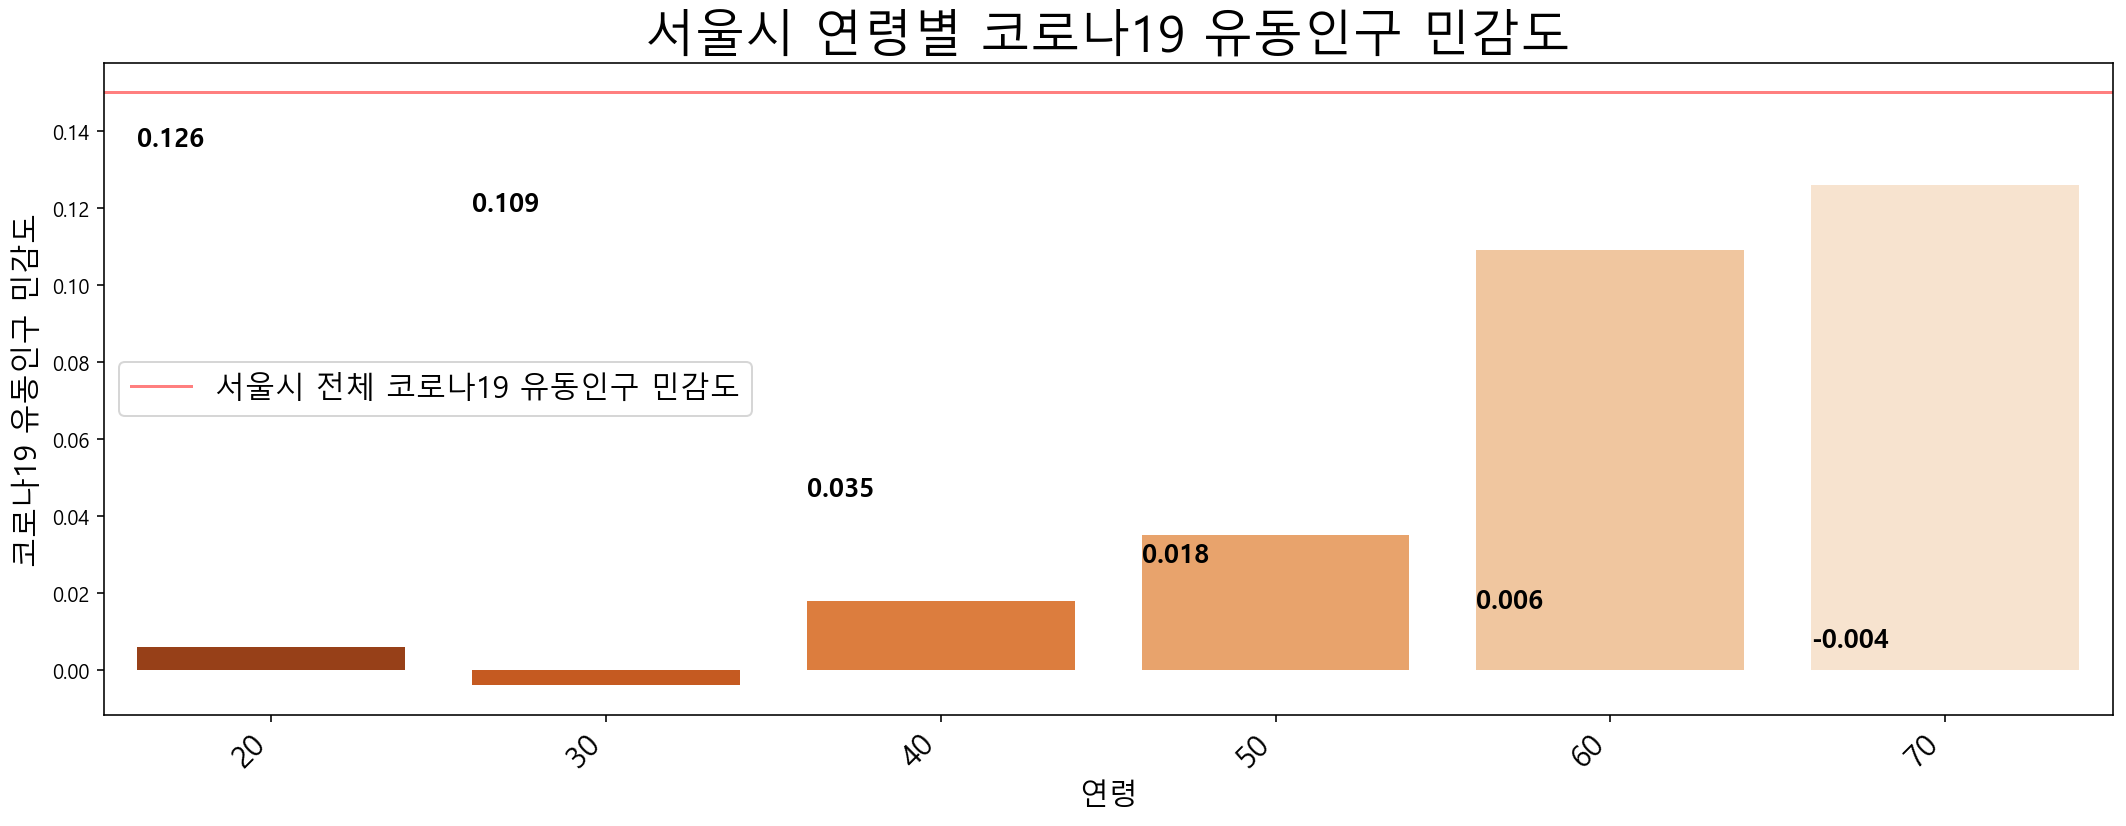

송파구의 연령별 코로나 유동인구 민감도


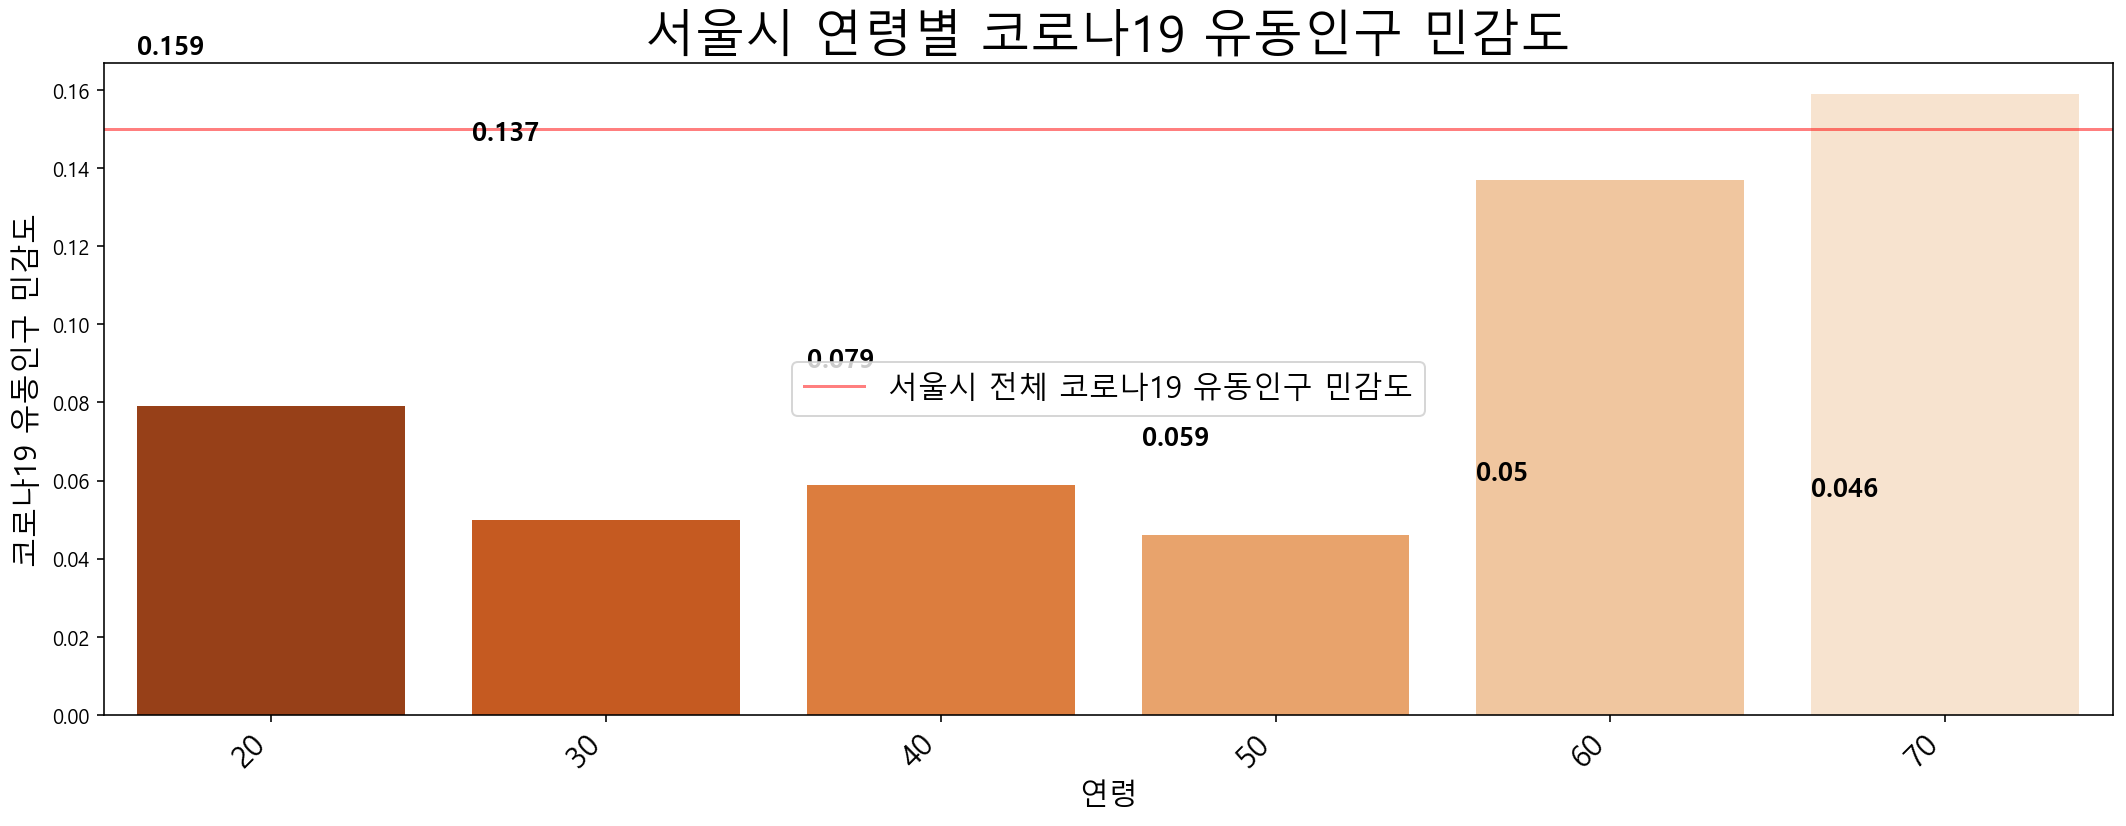

양천구의 연령별 코로나 유동인구 민감도


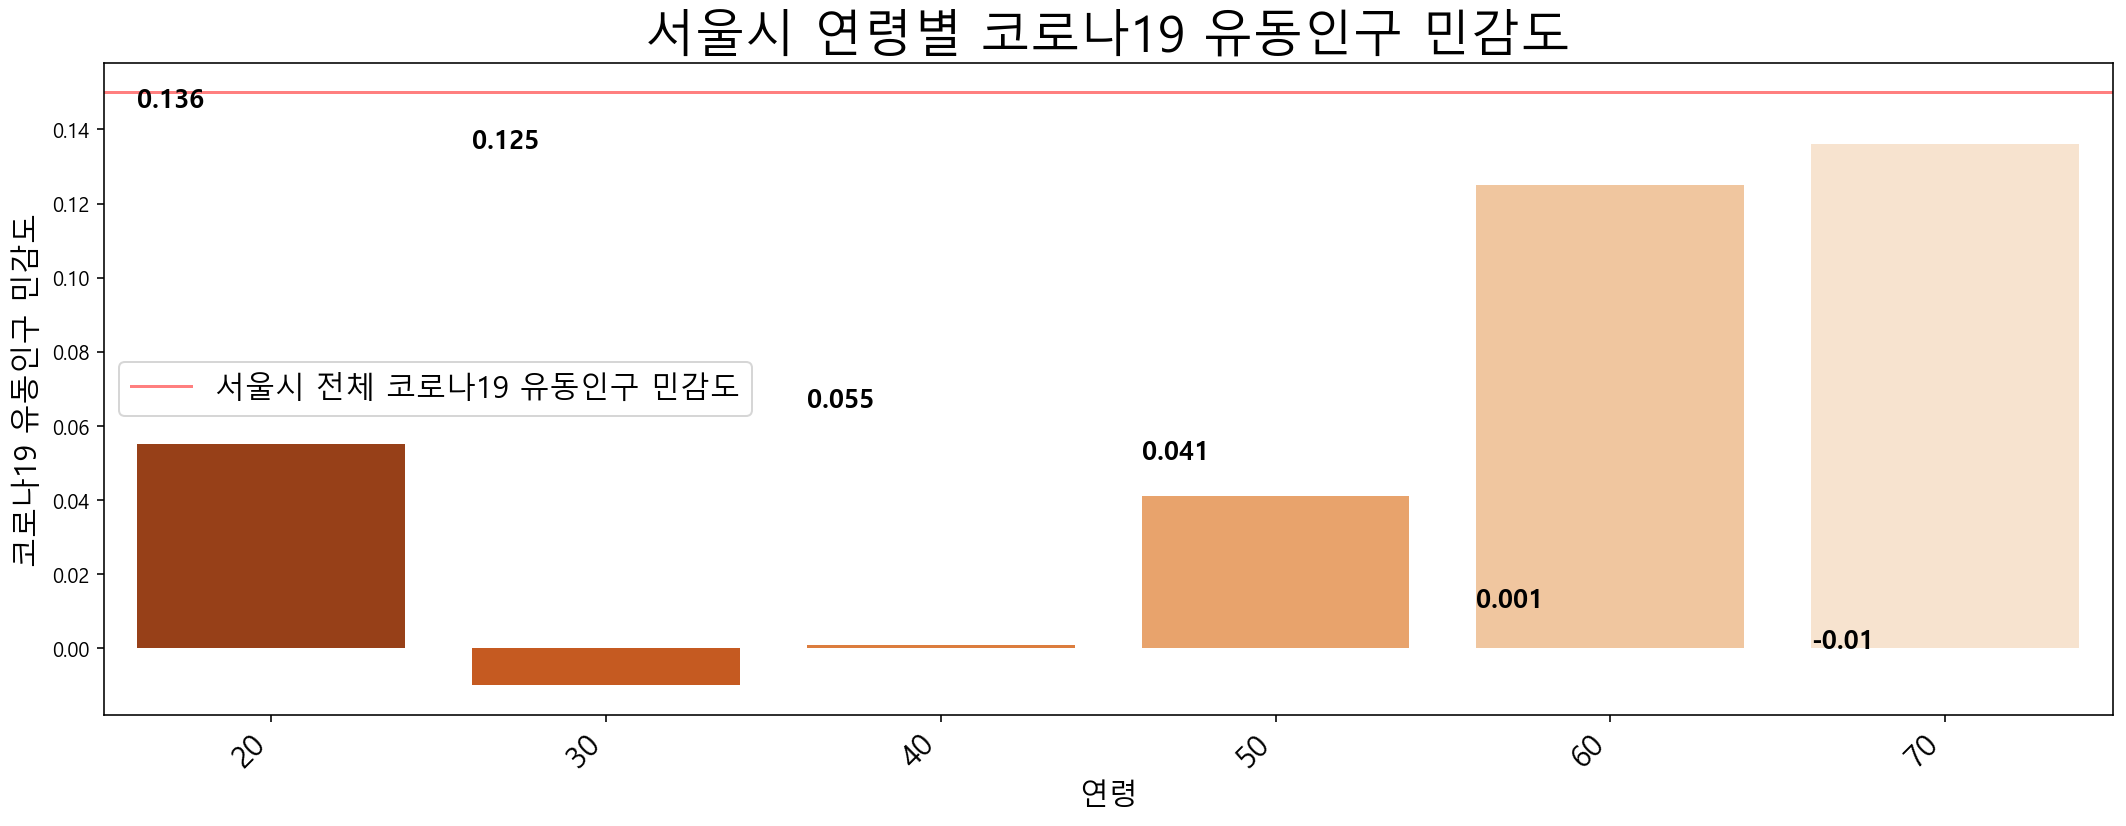

영등포구의 연령별 코로나 유동인구 민감도


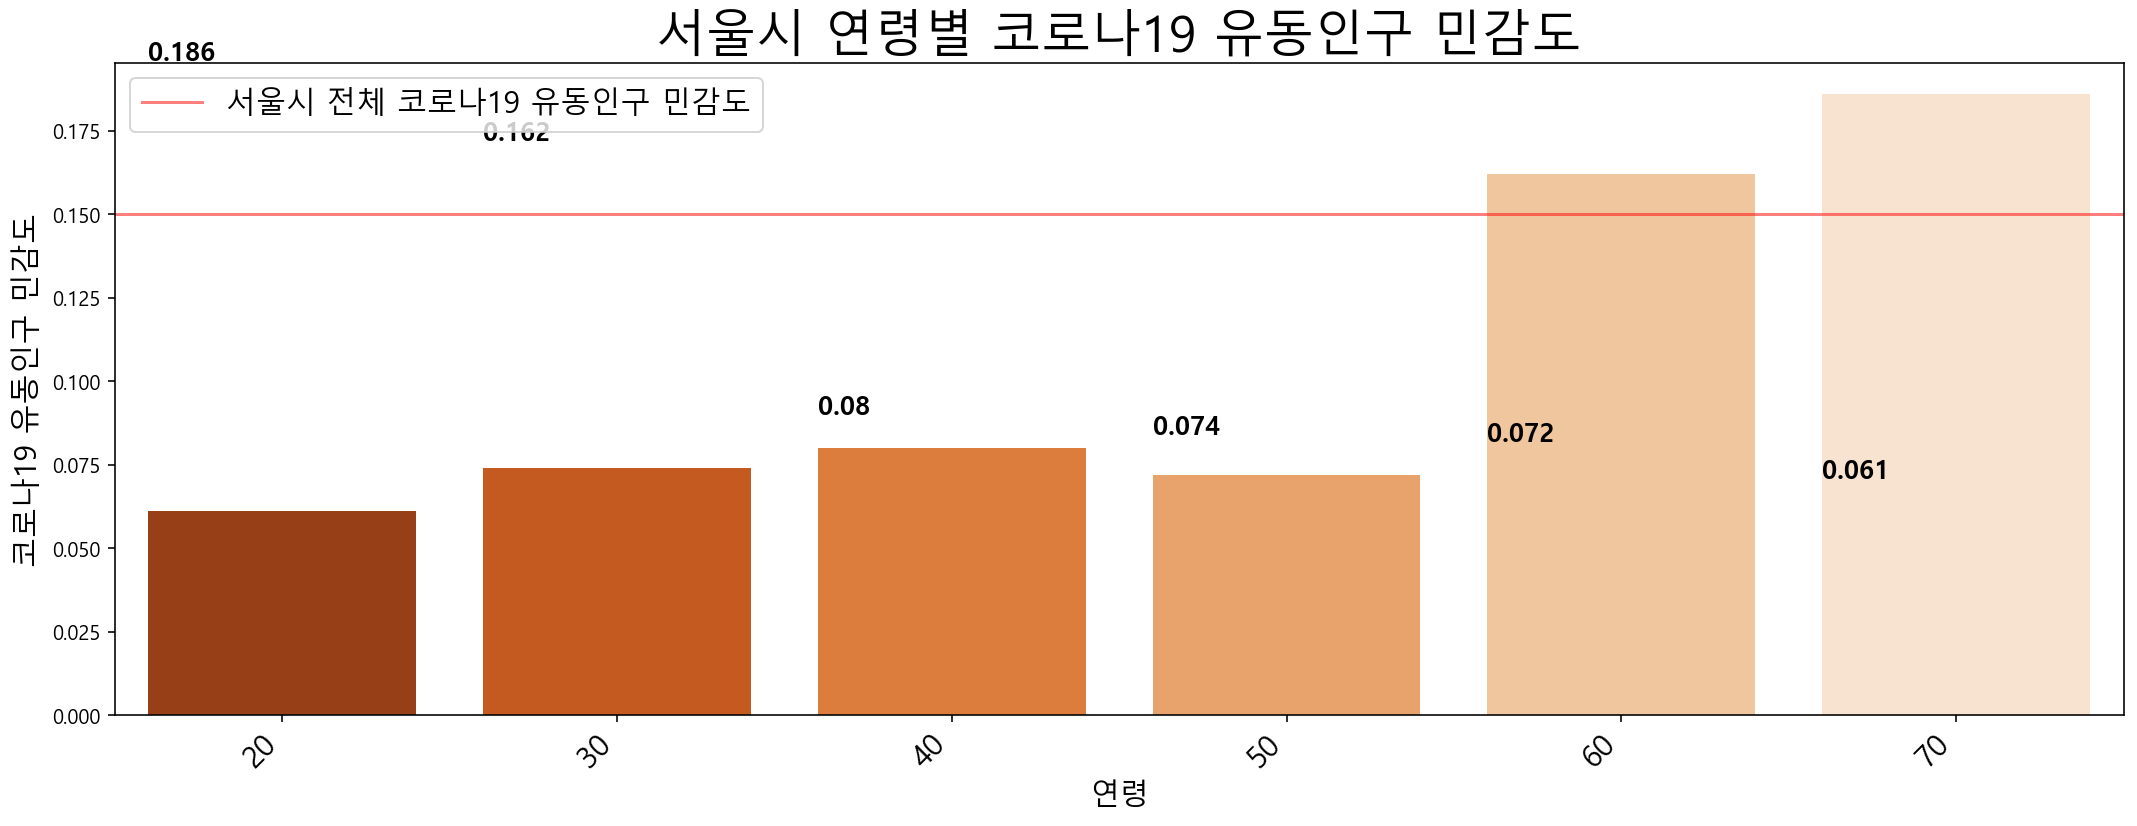

용산구의 연령별 코로나 유동인구 민감도


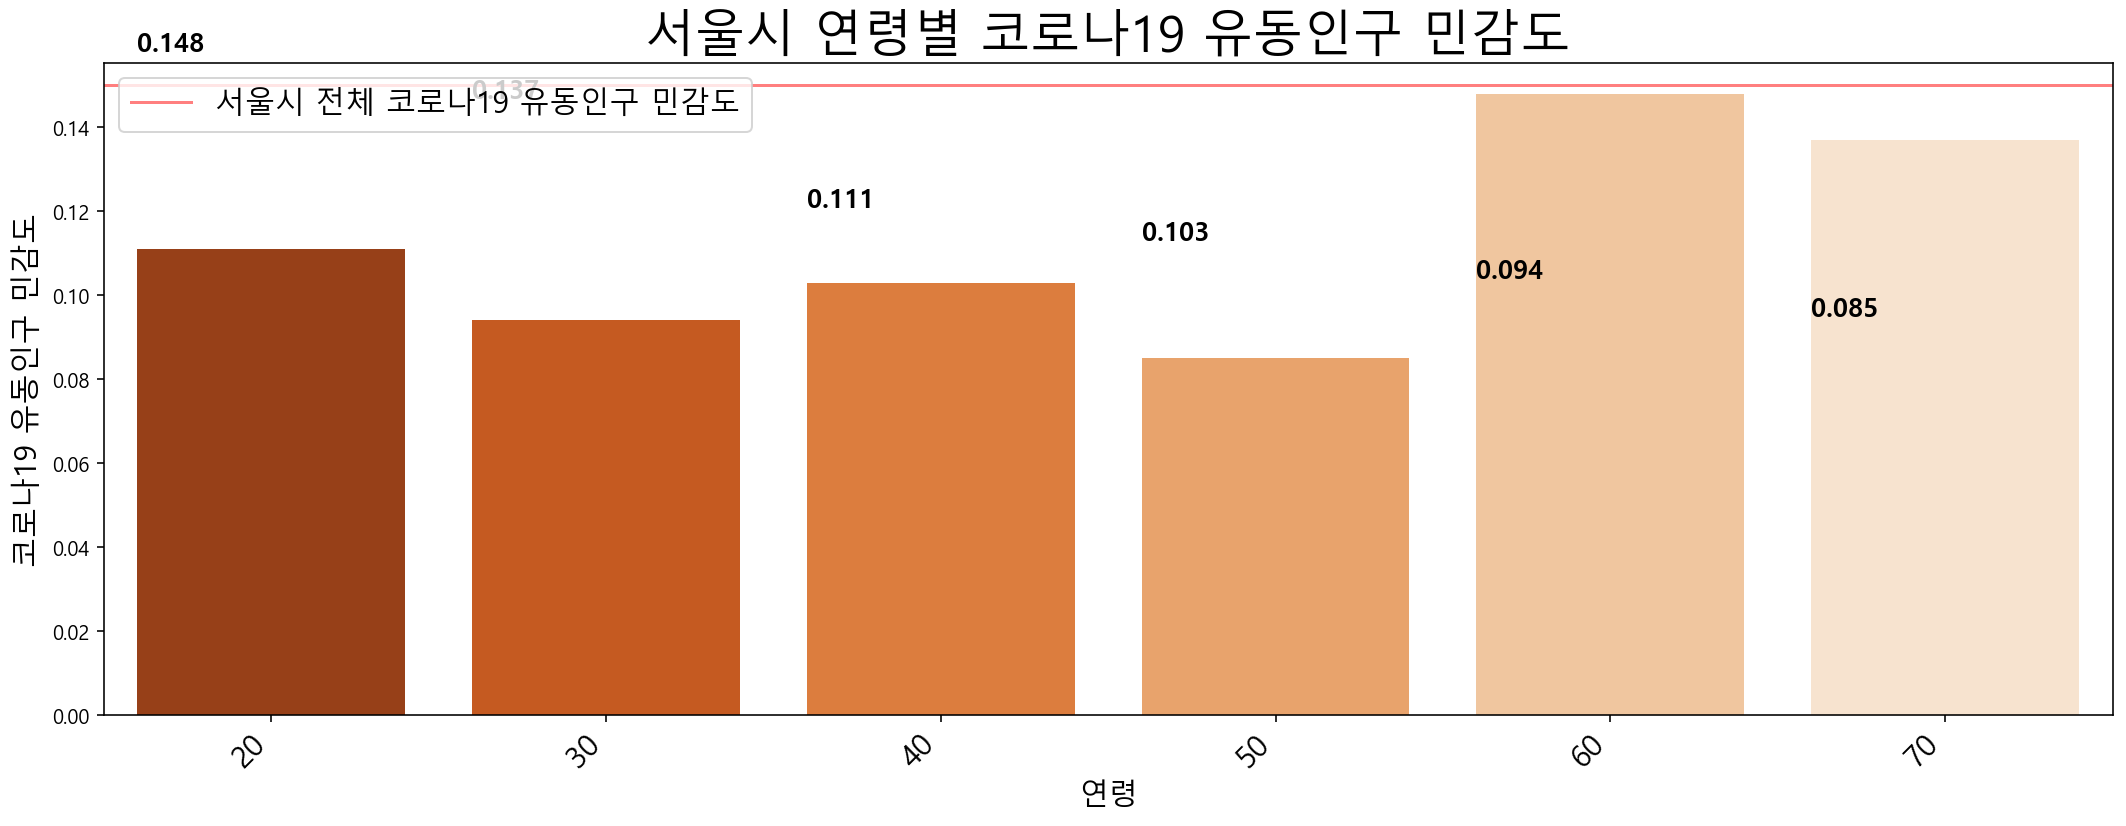

은평구의 연령별 코로나 유동인구 민감도


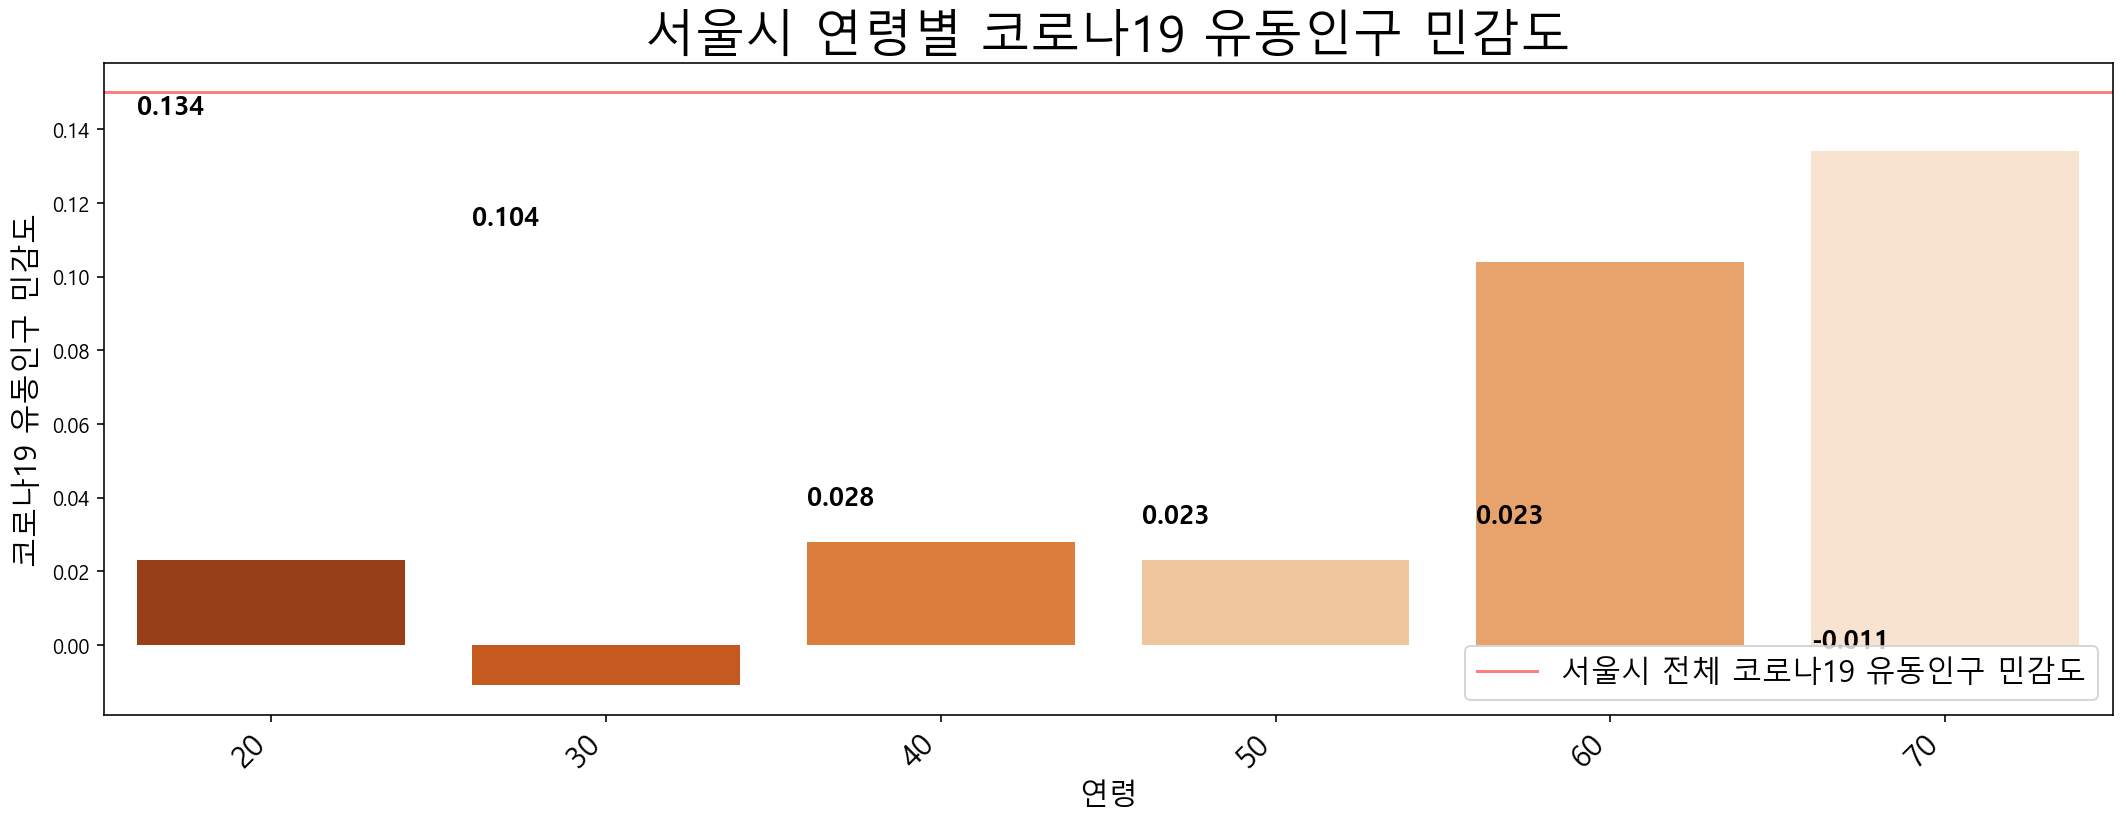

종로구의 연령별 코로나 유동인구 민감도


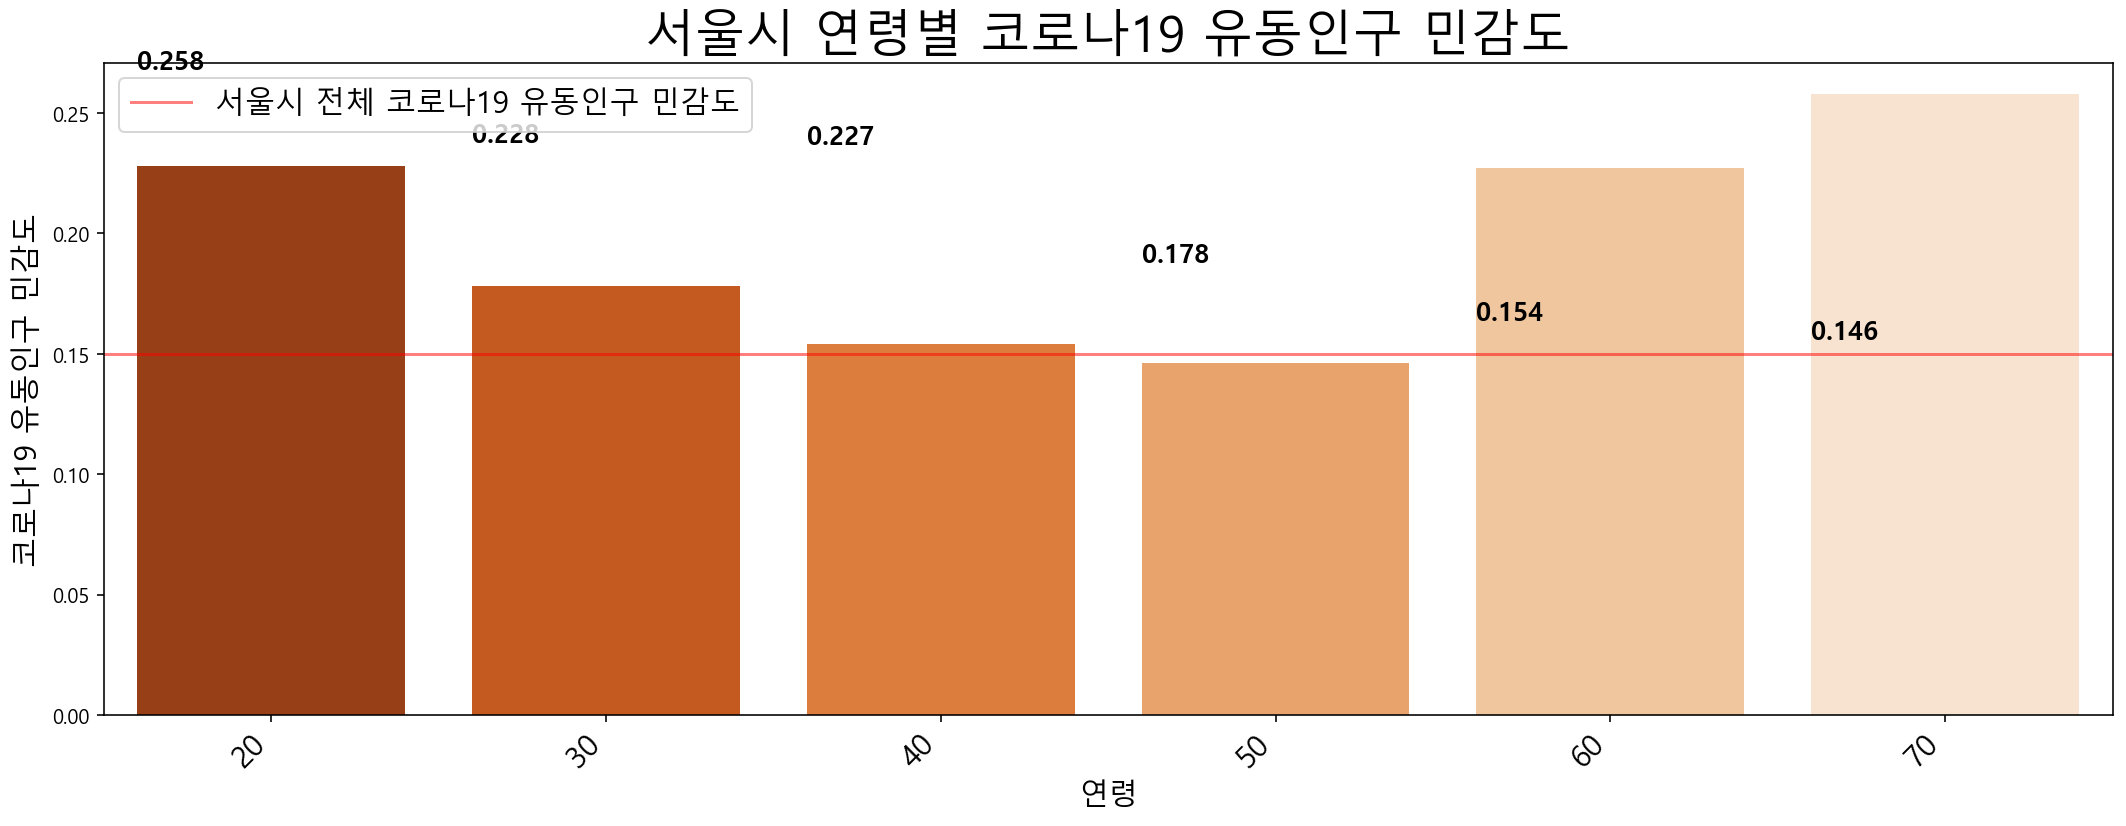

중구의 연령별 코로나 유동인구 민감도


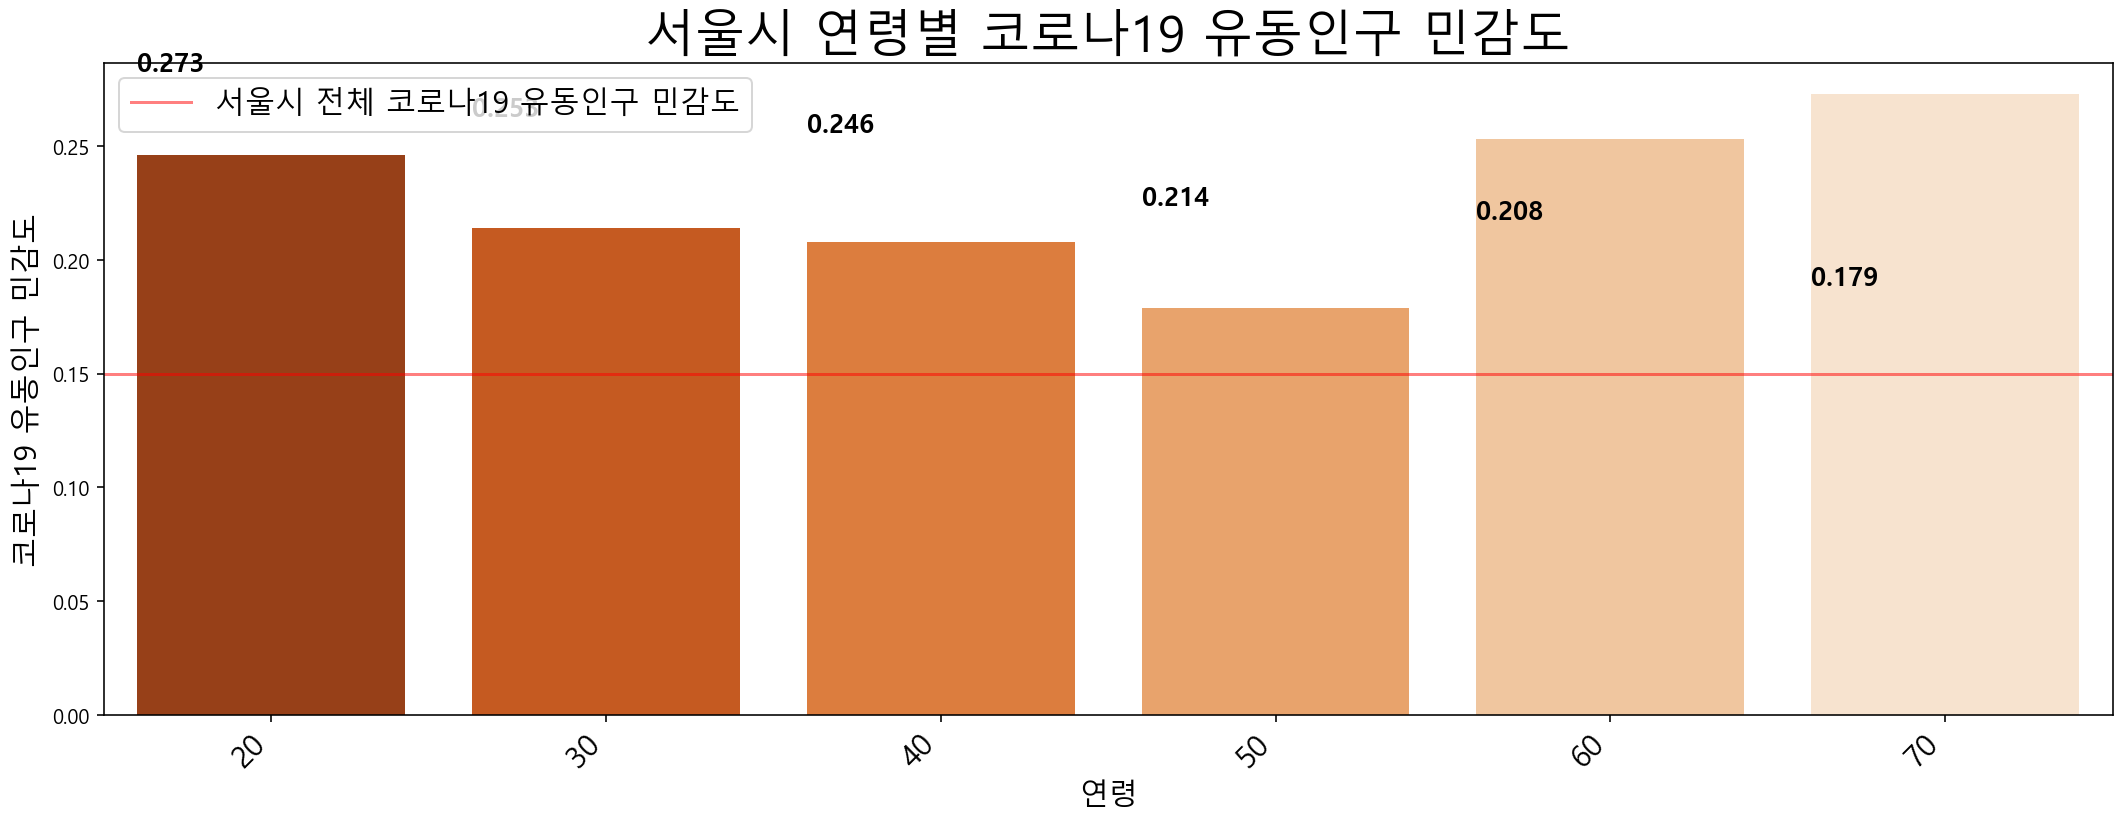

중랑구의 연령별 코로나 유동인구 민감도


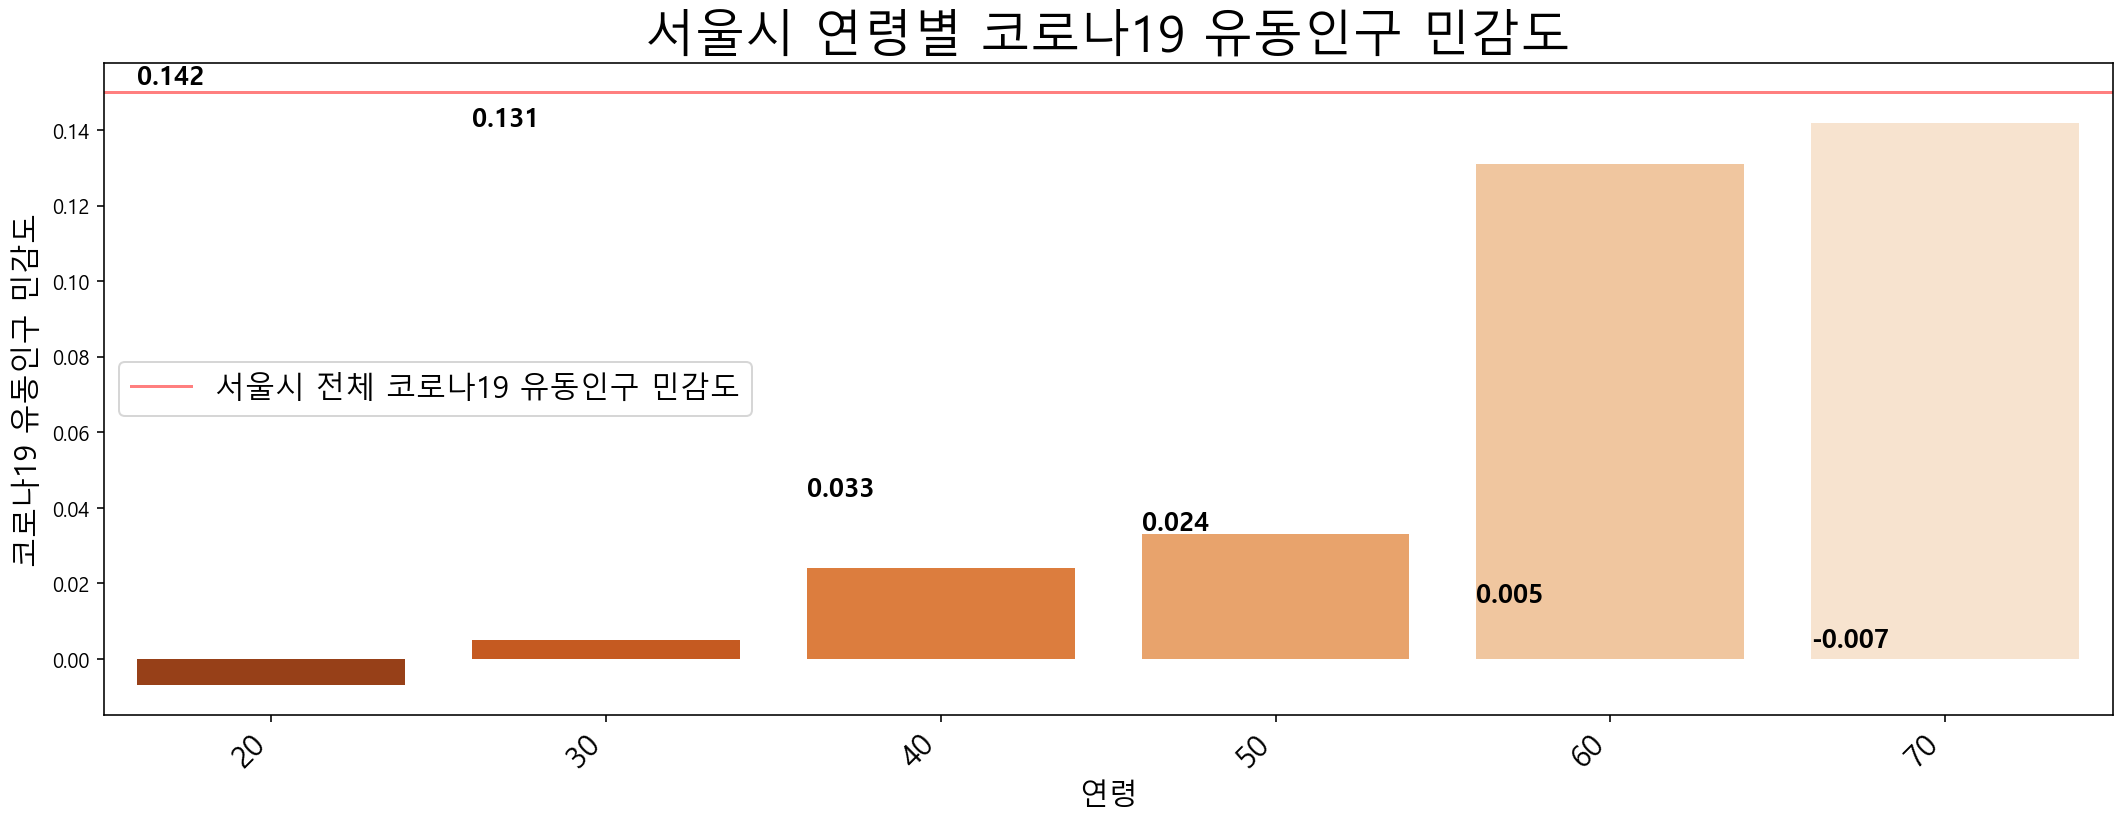

In [98]:
for gu in gu_list:
    print('{}의 연령별 코로나 유동인구 민감도'.format(gu))
    tmp_list = []
    for age in k[k.loc[:]['gu']==gu].age.unique():
      tmp_df = k[k.loc[:]['gu']==gu][k[k.loc[:]['gu']==gu].age==age]
      tmp_pre = tmp_df.loc[k[k.loc[:]['gu']==gu].week.isin(range(2,4)), 'ppl'].mean()
      tmp_post = tmp_df.loc[k[k.loc[:]['gu']==gu].week.isin(range(9, 12)), 'ppl'].mean()
      tmp_sensitivity = round((tmp_pre - tmp_post)/tmp_pre, 3)
      tmp_list.append(tmp_sensitivity)

    fpop_sensitivity_gu = pd.DataFrame({'연령':k[k.loc[:]['gu']==gu].age.unique(), '코로나19_유동인구_민감도':tmp_list})\
                            .sort_values('코로나19_유동인구_민감도', ascending=False).reset_index(drop=True)

    # 자치구별 코로나19 유동인구 민감도 막대 그래프
    plot_region_fpop_sensitivity(df=fpop_sensitivity_gu, x_axis='연령')




In [63]:
def plot_region_age_fpop(df, gu_nm):
  region = gu_nm
  tmp_df = df[df.age==gu_nm].copy()\
                .groupby('week')['ppl'].sum().divide(7000000).round(2).reset_index()
  pre_fpop = tmp_df.loc[tmp_df.week.isin(range(2,4)), 'ppl'].sum()/2
  post_fpop = tmp_df.loc[tmp_df.week.isin(range(9,13)), 'ppl'].sum()/4
  fpop_sensitivity = round((pre_fpop - post_fpop)/(pre_fpop), 3)

  tmp_df['week'] = tmp_df['week'].apply(lambda x : f'weekofyear_{x}')
  

  plt.figure(figsize=(18, 6))
  pal = sns.color_palette("Greens_d", tmp_df.shape[0])
  rank = tmp_df['ppl'].argsort().argsort()
  sns.barplot(x='week', y='ppl', data=tmp_df, palette=np.array(pal[::-1])[rank])
  plt.plot([1.5, 9.5], [pre_fpop, post_fpop], '-or', label=f'{region} 코로나19 유동인구 민감도 : {fpop_sensitivity}')
  plt.text(1, pre_fpop*1.05, f'2-3주차 평균\n({pre_fpop:.3f})', size=15)
  plt.text(9, post_fpop*1.05, f'9-12주차 평균\n({post_fpop:.3f})', size=15)
  plt.axvspan(1.5-1, 1.5+1, color='red', alpha=0.2)
  plt.axvspan(9.5-2, 9.5+2, color='red', alpha=0.2)

  plt.title(f'{region} 주차별 일평균 유동인구', size=20)
  plt.xticks(rotation=45, size=15, ha='right')
  plt.xlabel('주차별', size=15)
  ylabel = '유동인구수(천명)' 
  plt.ylabel(ylabel, size=15)
  plt.legend(fontsize=15, loc='upper right')
  plt.ylim(0, tmp_df.ppl.max()*1.2)
  plt.show()


In [66]:
for gu in gu_list:
    print('{}의 연령별 코로나 유동인구 민감도'.format(gu))
    print(k[k.loc[:]['gu']==gu])

강남구의 연령별 코로나 유동인구 민감도
      gu  age  week   ppl
0    강남구   20     1  1.90
1    강남구   20     2  2.98
2    강남구   20     3  2.99
3    강남구   20     4  2.46
4    강남구   20     5  2.71
..   ...  ...   ...   ...
181  강남구   70    27  0.91
182  강남구   70    28  0.91
183  강남구   70    29  0.90
184  강남구   70    30  0.90
185  강남구   70    31  0.66

[186 rows x 4 columns]
강동구의 연령별 코로나 유동인구 민감도
      gu  age  week   ppl
186  강동구   20     1  0.96
187  강동구   20     2  1.31
188  강동구   20     3  1.31
189  강동구   20     4  1.26
190  강동구   20     5  1.31
..   ...  ...   ...   ...
367  강동구   70    27  0.70
368  강동구   70    28  0.70
369  강동구   70    29  0.70
370  강동구   70    30  0.70
371  강동구   70    31  0.50

[186 rows x 4 columns]
강북구의 연령별 코로나 유동인구 민감도
      gu  age  week   ppl
372  강북구   20     1  0.65
373  강북구   20     2  0.88
374  강북구   20     3  0.87
375  강북구   20     4  0.87
376  강북구   20     5  0.89
..   ...  ...   ...   ...
553  강북구   70    27  0.74
554  강북구   70    28  0.74
555  강북구   70    29  0.73
55

In [64]:
for gu in gu_list:
    print('{}의 연령별 코로나 유동인구 민감도'.format(gu))
    plot_region_age_fpop(k[k.loc[:]['gu']==gu], gu_nm='20')
    plot_region_age_fpop(k[k.loc[:]['gu']==gu], gu_nm='30')
    plot_region_age_fpop(k[k.loc[:]['gu']==gu], gu_nm='70')

강남구의 연령별 코로나 유동인구 민감도


C:\Users\user\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
<ipython-input-63-f57559ebd76f>:7: RuntimeWarning: invalid value encountered in double_scalars
  fpop_sensitivity = round((pre_fpop - post_fpop)/(pre_fpop), 3)


ValueError: min() arg is an empty sequence

<Figure size 1296x432 with 0 Axes>